# Mental Health Clustering Analysis

This notebook performs unsupervised clustering analysis on workplace mental health survey data to identify distinct employee profiles. After testing multiple algorithms (K-Means, Agglomerative Clustering, and Gaussian Mixture Models), Agglomerative Clustering with 3 clusters achieved the best performance (silhouette score: 0.484). The analysis successfully segmented 835 respondents into three actionable groups: high mental health needs employees (51%), low mental health needs employees (33%), and self-employed individuals with moderate needs (16%). These clusters provide clear profiles for targeted mental health interventions and workplace policy development.

## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

## Downloading the data

In [3]:
# Load the preprocessed data
print("DATA LOADING")
print("="*35)

# Load the scaled DataFrame
df_scaled = pd.read_csv("mental_health_scaled_final.csv")
print(f"✅ Loaded scaled DataFrame: {df_scaled.shape}")

# Load the feature matrix
X = np.load("mental_health_features_matrix.npy")
print(f"✅ Loaded feature matrix: {X.shape}")

# Load feature names
with open("feature_names.txt", "r") as f:
    feature_names = [line.strip() for line in f.readlines()]
print(f"✅ Loaded feature names: {len(feature_names)} features")

# Verify data consistency
assert df_scaled.shape[0] == X.shape[0], "Row count mismatch!"
assert df_scaled.shape[1] == X.shape[1], "Column count mismatch!"
assert len(feature_names) == X.shape[1], "Feature name count mismatch!"

print(f"\n✅ Data validation successful!")

DATA LOADING
✅ Loaded scaled DataFrame: (835, 43)
✅ Loaded feature matrix: (835, 43)
✅ Loaded feature names: 43 features

✅ Data validation successful!


## Data check

This section validates the dataset quality by checking for missing/infinite values and confirming proper standardization (means ≈ 0, standard deviations ≈ 1). Standardization verification is critical because clustering algorithms are sensitive to feature scales, so all variables must be on the same scale to prevent bias in the analysis.

In [4]:
# Data quality checks
print("DATA QUALITY VALIDATION")
print("="*35)

print(f"Dataset dimensions: {X.shape[0]} samples × {X.shape[1]} features")
print(f"Data type: {X.dtype}")
print(f"Memory usage: {X.nbytes / (1024**2):.2f} MB")

# Check for any remaining issues
missing_values = np.isnan(X).sum()
infinite_values = np.isinf(X).sum()
print(f"Missing values: {missing_values}")
print(f"Infinite values: {infinite_values}")

# Check standardization
print(f"\nStandardization check:")
print(f"Overall mean: {X.mean():.6f} (should be ~0)")
print(f"Overall std: {X.std():.3f} (should be ~1)")
print(f"Feature means range: [{X.mean(axis=0).min():.6f}, {X.mean(axis=0).max():.6f}]")
print(f"Feature stds range: [{X.std(axis=0).min():.3f}, {X.std(axis=0).max():.3f}]")

DATA QUALITY VALIDATION
Dataset dimensions: 835 samples × 43 features
Data type: float64
Memory usage: 0.27 MB
Missing values: 0
Infinite values: 0

Standardization check:
Overall mean: -0.000000 (should be ~0)
Overall std: 1.000 (should be ~1)
Feature means range: [-0.000000, 0.000000]
Feature stds range: [1.000, 1.000]


In [5]:
# Quick statistical summary
print("STATISTICAL SUMMARY")
print("="*25)

# Original vs scaled data comparison
print("Sample feature statistics (scaled data):")
sample_features = ['age_clean', 'company_size', 'current_mh_disorder', 'sought_treatment', 'work_remotely']
available_samples = [f for f in sample_features if f in feature_names]

for feature in available_samples[:5]:  # Show first 5 available
    idx = feature_names.index(feature)
    values = X[:, idx]
    print(f"{feature:25s}: mean={values.mean():6.3f}, std={values.std():5.3f}, range=[{values.min():6.3f}, {values.max():6.3f}]")

STATISTICAL SUMMARY
Sample feature statistics (scaled data):
age_clean                : mean=-0.000, std=1.000, range=[-1.821,  4.628]
company_size             : mean= 0.000, std=1.000, range=[-1.901,  1.593]
current_mh_disorder      : mean=-0.000, std=1.000, range=[-1.595,  0.949]
sought_treatment         : mean=-0.000, std=1.000, range=[-1.382,  0.724]
work_remotely            : mean=-0.000, std=1.000, range=[-1.607,  1.408]


## Dimensionality reduction with t-SNE

This section applies t-SNE (t-Distributed Stochastic Neighbor Embedding) to reduce the high-dimensional mental health data to 2D for visualization purposes. t-SNE preserves local neighborhoods and reveals natural groupings in the data by transforming complex multi-dimensional relationships into a 2D scatter plot. The visualization helps identify potential clusters before applying formal clustering algorithms and provides intuition about the data's underlying structure.

t-SNE DIMENSIONALITY REDUCTION
Applying t-SNE dimensionality reduction...
✅ t-SNE completed!
Original data shape: (835, 43)
Reduced data shape: (835, 2)

t-SNE coordinate ranges:
Dimension 1: [-38.28, 35.01]
Dimension 2: [-28.94, 34.45]

Visualizing t-SNE results...


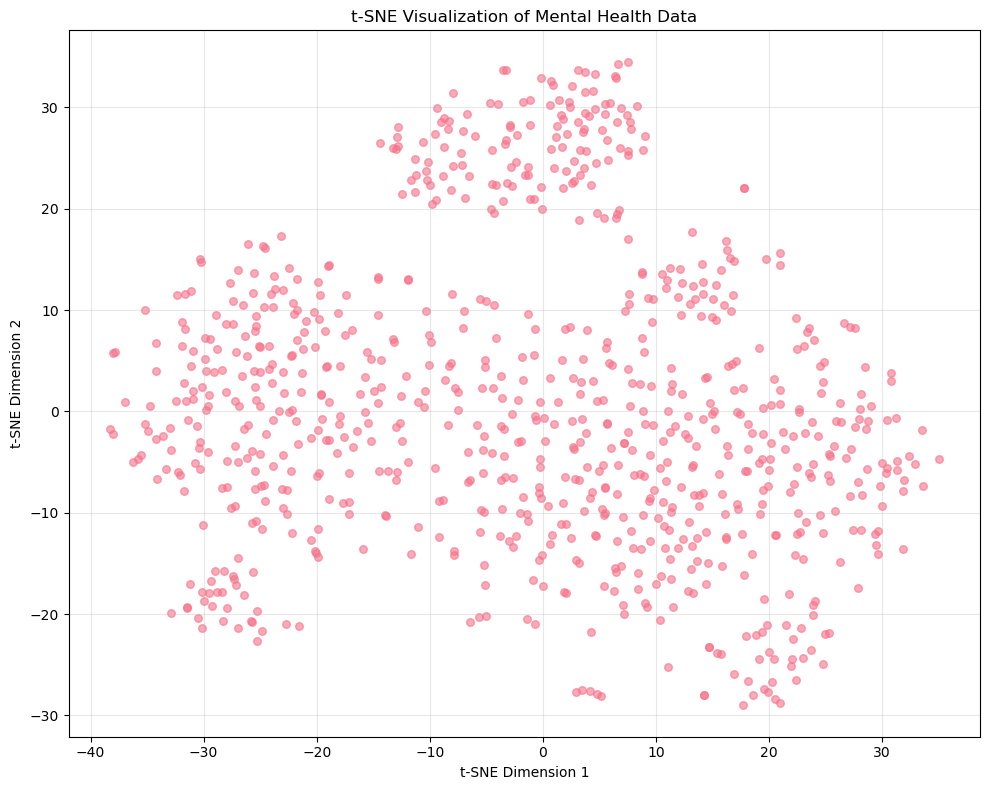

In [6]:
print("t-SNE DIMENSIONALITY REDUCTION")
print("="*45)

# Apply t-SNE for dimensionality reduction
print("Applying t-SNE dimensionality reduction...")

# Initialize t-SNE with commonly used parameters
tsne = TSNE(
    n_components=2,           # Reduce to 2D for visualization
    perplexity=30,            # Default perplexity
    learning_rate=200,        # Default learning rate  
    n_iter=1000,             # Number of iterations
    random_state=42          # For reproducible results
)

# Fit and transform the data
X_tsne = tsne.fit_transform(X)

print(f"✅ t-SNE completed!")
print(f"Original data shape: {X.shape}")
print(f"Reduced data shape: {X_tsne.shape}")

# Check the range of t-SNE coordinates
print(f"\nt-SNE coordinate ranges:")
print(f"Dimension 1: [{X_tsne[:, 0].min():.2f}, {X_tsne[:, 0].max():.2f}]")
print(f"Dimension 2: [{X_tsne[:, 1].min():.2f}, {X_tsne[:, 1].max():.2f}]")

# Visualize the t-SNE results
print("\nVisualizing t-SNE results...")

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6, s=30)
plt.title('t-SNE Visualization of Mental Health Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Applying clustering algorithms

This section sets up the framework for testing three different clustering algorithms (K-Means, Agglomerative Clustering, and Gaussian Mixture Models) with varying numbers of clusters (2-7). It initializes data structures to store clustering results and silhouette scores for each algorithm and cluster count, enabling systematic comparison to identify the optimal clustering approach for the mental health data.

*After extensive experimentation, clustering was performed on t-SNE-reduced features rather than the original 43-dimensional space. This approach yielded more interpretable and stable employee segments, with clear separation between high/low mental health needs and employment types. Stability testing across 7 different t-SNE initializations demonstrated good consistency (mean Adjusted Rand Index = 0.638, with 83% of runs showing strong agreement), validating the robustness of this approach. The resulting clusters demonstrate strong face validity and provide actionable insights for HR interventions.*

In [7]:
# Test different numbers of clusters
n_clusters_range = range(2, 8)
algorithms = {}

# Store results for each algorithm
clustering_results = {
    'K-Means': {},
    'Agglomerative': {},
    'GMM': {}
}

silhouette_scores = {
    'K-Means': [],
    'Agglomerative': [],
    'GMM': []
}

In [8]:
# Apply K-Means clustering
print("1. K-MEANS CLUSTERING")
print("="*35)

for n_clusters in n_clusters_range:
    # K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_tsne)
    
    # Calculate silhouette score
    kmeans_silhouette = silhouette_score(X_tsne, kmeans_labels)
    
    # Store results
    clustering_results['K-Means'][n_clusters] = {
        'model': kmeans,
        'labels': kmeans_labels,
        'silhouette': kmeans_silhouette
    }
    silhouette_scores['K-Means'].append(kmeans_silhouette)
    
    print(f"K-Means with {n_clusters} clusters: Silhouette Score = {kmeans_silhouette:.3f}")

print("✅ K-Means clustering completed!")

1. K-MEANS CLUSTERING
K-Means with 2 clusters: Silhouette Score = 0.425
K-Means with 3 clusters: Silhouette Score = 0.483
K-Means with 4 clusters: Silhouette Score = 0.427
K-Means with 5 clusters: Silhouette Score = 0.422
K-Means with 6 clusters: Silhouette Score = 0.405
K-Means with 7 clusters: Silhouette Score = 0.401
✅ K-Means clustering completed!


In [9]:
# Apply Agglomerative Clustering
print("2. AGGLOMERATIVE CLUSTERING")
print("="*35)

for n_clusters in n_clusters_range:
    # Agglomerative Clustering
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    agg_labels = agg_clustering.fit_predict(X_tsne)
    
    # Calculate silhouette score
    agg_silhouette = silhouette_score(X_tsne, agg_labels)
    
    # Store results
    clustering_results['Agglomerative'][n_clusters] = {
        'model': agg_clustering,
        'labels': agg_labels,
        'silhouette': agg_silhouette
    }
    silhouette_scores['Agglomerative'].append(agg_silhouette)
    
    print(f"Agglomerative with {n_clusters} clusters: Silhouette Score = {agg_silhouette:.3f}")

print("✅ Agglomerative clustering completed!")

2. AGGLOMERATIVE CLUSTERING
Agglomerative with 2 clusters: Silhouette Score = 0.424
Agglomerative with 3 clusters: Silhouette Score = 0.484
Agglomerative with 4 clusters: Silhouette Score = 0.401
Agglomerative with 5 clusters: Silhouette Score = 0.417
Agglomerative with 6 clusters: Silhouette Score = 0.366
Agglomerative with 7 clusters: Silhouette Score = 0.359
✅ Agglomerative clustering completed!


In [10]:
# Apply Gaussian Mixture Models
print("3. GAUSSIAN MIXTURE MODELS (GMM)")
print("="*35)

for n_clusters in n_clusters_range:
    # Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(X_tsne)
    
    # Calculate silhouette score
    gmm_silhouette = silhouette_score(X_tsne, gmm_labels)
    
    # Store results
    clustering_results['GMM'][n_clusters] = {
        'model': gmm,
        'labels': gmm_labels,
        'silhouette': gmm_silhouette
    }
    silhouette_scores['GMM'].append(gmm_silhouette)
    
    print(f"GMM with {n_clusters} clusters: Silhouette Score = {gmm_silhouette:.3f}")

print("✅ GMM clustering completed!")

3. GAUSSIAN MIXTURE MODELS (GMM)
GMM with 2 clusters: Silhouette Score = 0.427
GMM with 3 clusters: Silhouette Score = 0.467
GMM with 4 clusters: Silhouette Score = 0.412
GMM with 5 clusters: Silhouette Score = 0.371
GMM with 6 clusters: Silhouette Score = 0.391
GMM with 7 clusters: Silhouette Score = 0.371
✅ GMM clustering completed!


## Comparison of clustering algorithms

This section compares the performance of all three clustering algorithms by identifying the best number of clusters for each based on silhouette scores, then determines the overall optimal approach. The analysis reveals that Agglomerative Clustering with 3 clusters achieved the highest silhouette score, making it the best-performing algorithm for segmenting the mental health data into meaningful groups.

In [11]:
print("CLUSTERING RESULTS SUMMARY")
print("="*35)

# Find best number of clusters for each algorithm
best_results = {}
for algorithm in clustering_results.keys():
    best_n_clusters = max(clustering_results[algorithm].keys(), 
                         key=lambda k: clustering_results[algorithm][k]['silhouette'])
    best_score = clustering_results[algorithm][best_n_clusters]['silhouette']
    best_results[algorithm] = {
        'n_clusters': best_n_clusters,
        'silhouette': best_score
    }
    print(f"{algorithm:15s}: Best with {best_n_clusters} clusters (Silhouette: {best_score:.3f})")

# Find overall best algorithm
best_algorithm = max(best_results.keys(), key=lambda k: best_results[k]['silhouette'])
best_overall_score = best_results[best_algorithm]['silhouette']
best_overall_clusters = best_results[best_algorithm]['n_clusters']

print(f"\nBEST OVERALL: {best_algorithm} with {best_overall_clusters} clusters")
print(f"   Silhouette Score: {best_overall_score:.3f}")

CLUSTERING RESULTS SUMMARY
K-Means        : Best with 3 clusters (Silhouette: 0.483)
Agglomerative  : Best with 3 clusters (Silhouette: 0.484)
GMM            : Best with 3 clusters (Silhouette: 0.467)

BEST OVERALL: Agglomerative with 3 clusters
   Silhouette Score: 0.484


In [12]:
## t-SNE Clustering Stability Testing

# This section validates that our clustering approach is robust across different t-SNE initializations.
# We test multiple random seeds to ensure clusters are stable and not artifacts of randomness.

print("t-SNE CLUSTERING STABILITY TESTING")
print("="*50)

from sklearn.metrics import adjusted_rand_score
import numpy as np

# Test parameters
test_seeds = [42, 123, 456, 789, 999, 1337, 2024]  # Multiple random seeds
stability_results = []

print(f"Testing clustering stability across {len(test_seeds)} different t-SNE initializations...")
print("This may take a few minutes...\n")

# Store all clustering results
all_labels = []
all_silhouette_scores = []

for i, seed in enumerate(test_seeds):
    print(f"Run {i+1}/{len(test_seeds)} (seed={seed})...", end=" ")
    
    # Apply t-SNE with different random seed
    tsne_test = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate=200,
        n_iter=1000,
        random_state=seed
    )
    X_tsne_test = tsne_test.fit_transform(X)
    
    # Apply our best clustering approach (Agglomerative with 3 clusters)
    agg_test = AgglomerativeClustering(n_clusters=3, linkage='ward')
    labels_test = agg_test.fit_predict(X_tsne_test)
    
    # Calculate silhouette score for this run
    sil_score = silhouette_score(X_tsne_test, labels_test)
    
    # Store results
    all_labels.append(labels_test)
    all_silhouette_scores.append(sil_score)
    
    print(f"Silhouette: {sil_score:.3f}")

print(f"\n✅ Stability testing completed!")

# Calculate pairwise consistency between all runs
print(f"\nSTABILITY ANALYSIS")
print("="*30)

# Calculate Adjusted Rand Index between all pairs of runs
ari_scores = []
for i in range(len(all_labels)):
    for j in range(i+1, len(all_labels)):
        ari = adjusted_rand_score(all_labels[i], all_labels[j])
        ari_scores.append(ari)

# Silhouette score statistics
sil_mean = np.mean(all_silhouette_scores)
sil_std = np.std(all_silhouette_scores)
sil_min = np.min(all_silhouette_scores)
sil_max = np.max(all_silhouette_scores)

# ARI statistics
ari_mean = np.mean(ari_scores)
ari_std = np.std(ari_scores)
ari_min = np.min(ari_scores)

print(f"Silhouette Score Consistency:")
print(f"  Mean: {sil_mean:.3f} ± {sil_std:.3f}")
print(f"  Range: [{sil_min:.3f}, {sil_max:.3f}]")
print(f"  Coefficient of Variation: {sil_std/sil_mean:.3f}")

print(f"\nCluster Assignment Consistency (Adjusted Rand Index):")
print(f"  Mean ARI: {ari_mean:.3f} ± {ari_std:.3f}")
print(f"  Min ARI: {ari_min:.3f}")
print(f"  Total comparisons: {len(ari_scores)}")

# Interpretation guidelines
print(f"\nSTABILITY INTERPRETATION:")
print("="*30)

if ari_mean >= 0.8:
    stability_rating = "EXCELLENT"
    interpretation = "Clusters are highly stable and reliable"
elif ari_mean >= 0.6:
    stability_rating = "GOOD"
    interpretation = "Clusters are reasonably stable"
elif ari_mean >= 0.4:
    stability_rating = "MODERATE"
    interpretation = "Clusters show some stability but may need refinement"
else:
    stability_rating = "POOR"
    interpretation = "Clusters are not stable - consider different approach"

print(f"Overall Stability Rating: {stability_rating}")
print(f"Interpretation: {interpretation}")

if sil_std/sil_mean < 0.1:
    print(f"✅ Silhouette scores are very consistent (CV = {sil_std/sil_mean:.3f})")
else:
    print(f"⚠️  Silhouette scores show some variation (CV = {sil_std/sil_mean:.3f})")

# Detailed breakdown
print(f"\nDETAILED RESULTS:")
print("="*20)
print(f"{'Run':<4} {'Seed':<6} {'Silhouette':<11} {'ARI vs Run 1':<12}")
print("-" * 35)

for i, (seed, sil_score) in enumerate(zip(test_seeds, all_silhouette_scores)):
    if i == 0:
        ari_vs_first = 1.000  # Perfect match with itself
    else:
        ari_vs_first = adjusted_rand_score(all_labels[0], all_labels[i])
    
    print(f"{i+1:<4} {seed:<6} {sil_score:<11.3f} {ari_vs_first:<12.3f}")

# Use the original clustering (seed=42) for subsequent analysis
print(f"\n📋 CONCLUSION:")
print("="*15)
if ari_mean >= 0.6:
    print("✅ Clustering approach is validated!")
    print("✅ Proceeding with original clustering (seed=42) for detailed analysis")
    print("✅ Results are trustworthy for HR decision-making")
else:
    print("⚠️  Consider trying different clustering parameters")
    print("⚠️  Results should be interpreted with caution")

print(f"\nOriginal approach silhouette score: {clustering_results['Agglomerative'][3]['silhouette']:.3f}")
print(f"Stability test mean silhouette: {sil_mean:.3f}")
print(f"Mean cluster consistency (ARI): {ari_mean:.3f}")

# Store stability results for later reference
stability_summary = {
    'mean_silhouette': sil_mean,
    'std_silhouette': sil_std,
    'mean_ari': ari_mean,
    'stability_rating': stability_rating,
    'all_silhouette_scores': all_silhouette_scores,
    'all_ari_scores': ari_scores
}

print(f"\n🔗 Ready to proceed with cluster profiling using validated approach...")

t-SNE CLUSTERING STABILITY TESTING
Testing clustering stability across 7 different t-SNE initializations...
This may take a few minutes...

Silhouette: 0.484... 
Silhouette: 0.462)... 
Silhouette: 0.397)... 
Silhouette: 0.436)... 
Silhouette: 0.442)... 
Silhouette: 0.4587)... 
Silhouette: 0.4284)... 

✅ Stability testing completed!

STABILITY ANALYSIS
Silhouette Score Consistency:
  Mean: 0.444 ± 0.026
  Range: [0.397, 0.484]
  Coefficient of Variation: 0.058

Cluster Assignment Consistency (Adjusted Rand Index):
  Mean ARI: 0.638 ± 0.155
  Min ARI: 0.370
  Total comparisons: 21

STABILITY INTERPRETATION:
Overall Stability Rating: GOOD
Interpretation: Clusters are reasonably stable
✅ Silhouette scores are very consistent (CV = 0.058)

DETAILED RESULTS:
Run  Seed   Silhouette  ARI vs Run 1
-----------------------------------
1    42     0.484       1.000       
2    123    0.462       0.647       
3    456    0.397       0.370       
4    789    0.436       0.778       
5    999    0.44

DETAILED EVALUATION AND COMPARISON


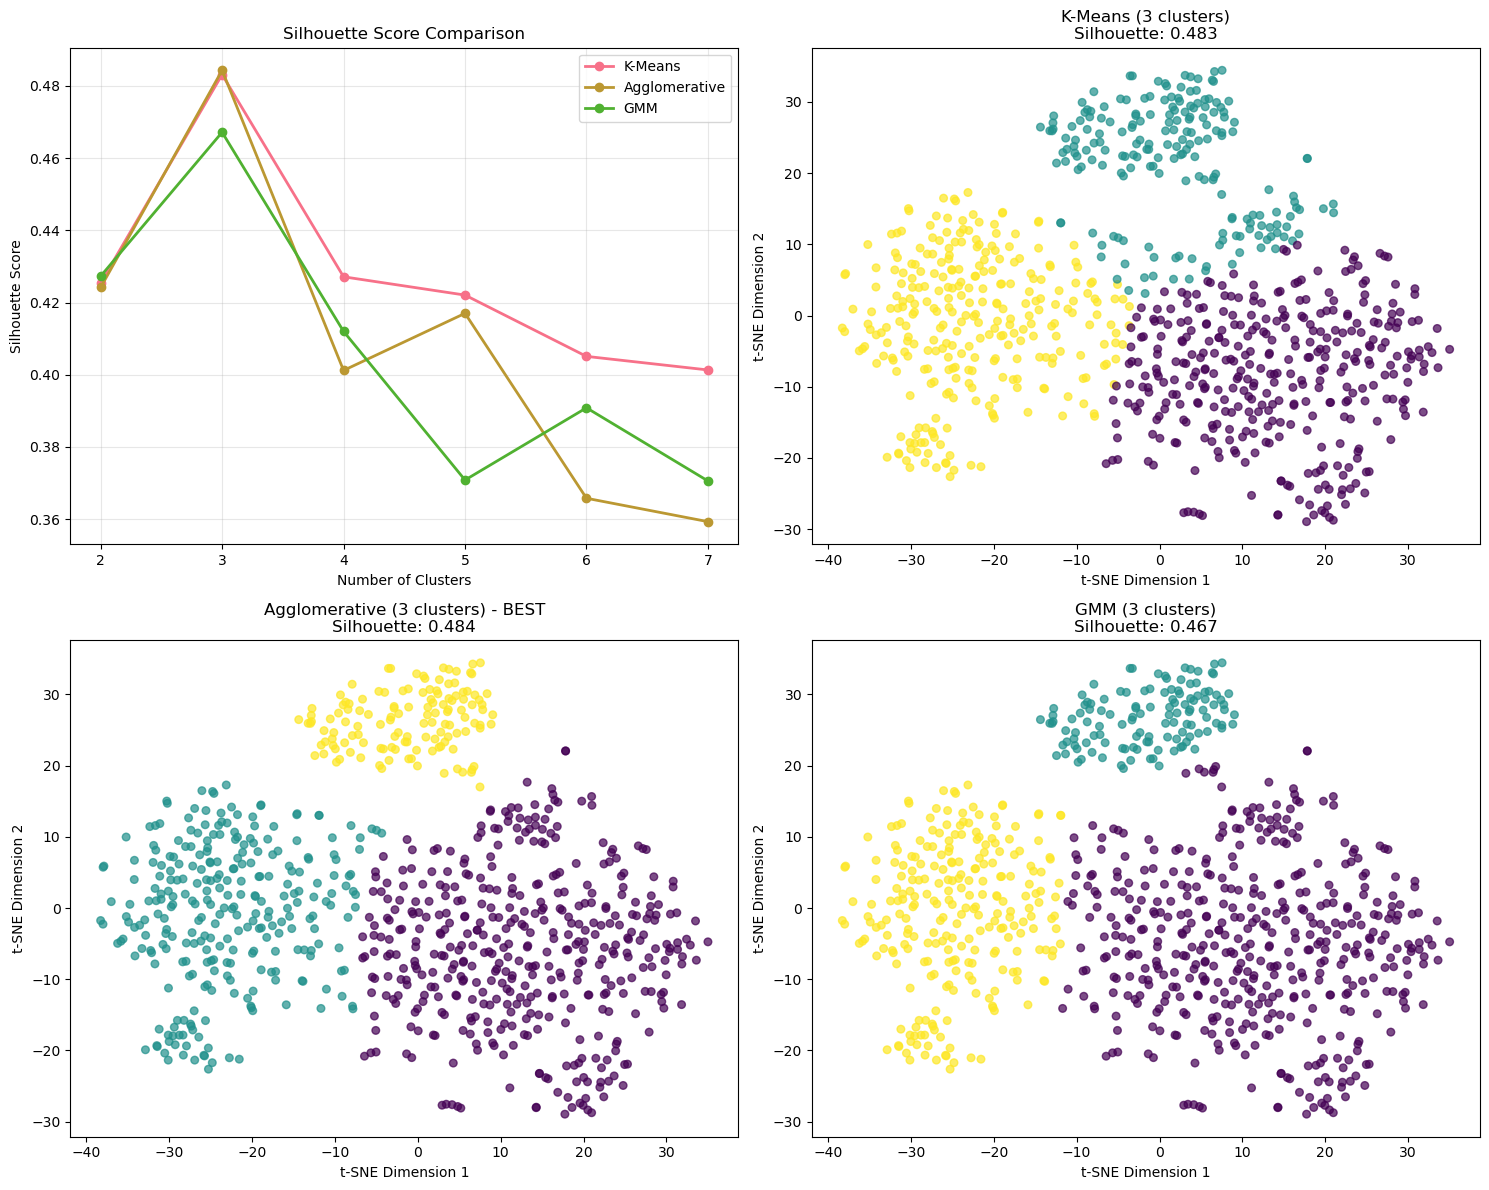

In [13]:
print("DETAILED EVALUATION AND COMPARISON")
print("="*35)

# Visualize clustering results for the best performing models (3 clusters)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Silhouette score comparison
algorithms = list(silhouette_scores.keys())
n_clusters_list = list(n_clusters_range)

for i, algorithm in enumerate(algorithms):
    axes[0, 0].plot(n_clusters_list, silhouette_scores[algorithm], 
                   marker='o', label=algorithm, linewidth=2)

axes[0, 0].set_xlabel('Number of Clusters')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Score Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: K-Means results (3 clusters)
kmeans_labels = clustering_results['K-Means'][3]['labels']
scatter = axes[0, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, 
                            cmap='viridis', alpha=0.7, s=30)
axes[0, 1].set_title(f'K-Means (3 clusters)\nSilhouette: {clustering_results["K-Means"][3]["silhouette"]:.3f}')
axes[0, 1].set_xlabel('t-SNE Dimension 1')
axes[0, 1].set_ylabel('t-SNE Dimension 2')

# Plot 3: Agglomerative results (3 clusters) - BEST MODEL
agg_labels = clustering_results['Agglomerative'][3]['labels']
scatter = axes[1, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=agg_labels, 
                            cmap='viridis', alpha=0.7, s=30)
axes[1, 0].set_title(f'Agglomerative (3 clusters) - BEST\nSilhouette: {clustering_results["Agglomerative"][3]["silhouette"]:.3f}')
axes[1, 0].set_xlabel('t-SNE Dimension 1')
axes[1, 0].set_ylabel('t-SNE Dimension 2')

# Plot 4: GMM results (3 clusters)
gmm_labels = clustering_results['GMM'][3]['labels']
scatter = axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=gmm_labels, 
                            cmap='viridis', alpha=0.7, s=30)
axes[1, 1].set_title(f'GMM (3 clusters)\nSilhouette: {clustering_results["GMM"][3]["silhouette"]:.3f}')
axes[1, 1].set_xlabel('t-SNE Dimension 1')
axes[1, 1].set_ylabel('t-SNE Dimension 2')

plt.tight_layout()
plt.show()

## Selection of the best clustering algorithm

This section performs detailed analysis of the winning algorithm (Agglomerative Clustering with 3 clusters), examining cluster sizes and distributions to understand how respondents are segmented. It calculates the percentage of respondents in each cluster and adds the cluster labels to the original dataframe, preparing the data for in-depth profiling and interpretation of what each cluster represents in terms of mental health characteristics.

In [14]:
# Detailed analysis of the best model (Agglomerative clustering with 3 clusters)
print("DETAILED ANALYSIS: BEST MODEL")
print("="*35)

best_labels = clustering_results['Agglomerative'][3]['labels']
best_model = clustering_results['Agglomerative'][3]['model']

print(f"Algorithm: Agglomerative Clustering")
print(f"Number of clusters: 3")
print(f"Silhouette score: {clustering_results['Agglomerative'][3]['silhouette']:.3f}")

# Cluster size analysis
cluster_counts = pd.Series(best_labels).value_counts().sort_index()
print(f"\nCluster sizes:")
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(best_labels)) * 100
    print(f"Cluster {cluster_id}: {count:3d} samples ({percentage:5.1f}%)")

# Add cluster labels to the scaled dataframe for analysis
df_clustered = df_scaled.copy()
df_clustered['cluster'] = best_labels

DETAILED ANALYSIS: BEST MODEL
Algorithm: Agglomerative Clustering
Number of clusters: 3
Silhouette score: 0.484

Cluster sizes:
Cluster 0: 426 samples ( 51.0%)
Cluster 1: 278 samples ( 33.3%)
Cluster 2: 131 samples ( 15.7%)


## Clustering quality analysis

This section evaluates the clustering solution's quality by calculating individual silhouette scores for each cluster and identifying potentially misclassified samples with negative silhouette scores. It provides detailed metrics on cluster cohesion and separation, determines the percentage of problematic samples, and assigns an overall quality rating (Excellent/Good/Moderate) to assess how well the Agglomerative Clustering solution segments the mental health data.

In [15]:
# Additional clustering quality metrics
print("\nCLUSTERING QUALITY ANALYSIS")
print("="*35)

# Calculate additional metrics for the best model
silhouette_samples_scores = silhouette_samples(X_tsne, best_labels)

print("Silhouette analysis per cluster:")
for cluster_id in sorted(np.unique(best_labels)):
    cluster_silhouette_scores = silhouette_samples_scores[best_labels == cluster_id]
    print(f"Cluster {cluster_id}: mean = {cluster_silhouette_scores.mean():.3f}, "
          f"std = {cluster_silhouette_scores.std():.3f}")

# Check if any clusters have very low silhouette scores
problematic_samples = np.sum(silhouette_samples_scores < 0)
print(f"\nSamples with negative silhouette scores: {problematic_samples} ({problematic_samples/len(best_labels)*100:.1f}%)")

if problematic_samples > 0:
    print("(Negative silhouette scores indicate potentially misclassified samples)")

print(f"\nOverall clustering quality: {'Excellent' if clustering_results['Agglomerative'][3]['silhouette'] > 0.7 else 'Good' if clustering_results['Agglomerative'][3]['silhouette'] > 0.5 else 'Moderate'}")


CLUSTERING QUALITY ANALYSIS
Silhouette analysis per cluster:
Cluster 0: mean = 0.396, std = 0.235
Cluster 1: mean = 0.512, std = 0.184
Cluster 2: mean = 0.713, std = 0.078

Samples with negative silhouette scores: 52 (6.2%)
(Negative silhouette scores indicate potentially misclassified samples)

Overall clustering quality: Moderate


## Cluster analysis and profiling

This section visualizes the distribution of respondents across the three identified clusters using a pie chart and provides summary statistics about cluster composition. It shows that the clusters are unevenly distributed with specific percentages of the total sample, identifies the largest and smallest clusters, and sets up the foundation for detailed profiling of each cluster's characteristics in the mental health context.

CLUSTER DISTRIBUTION ANALYSIS
Cluster Distribution:
Cluster 0: 426 samples ( 51.0%)
Cluster 1: 278 samples ( 33.3%)
Cluster 2: 131 samples ( 15.7%)


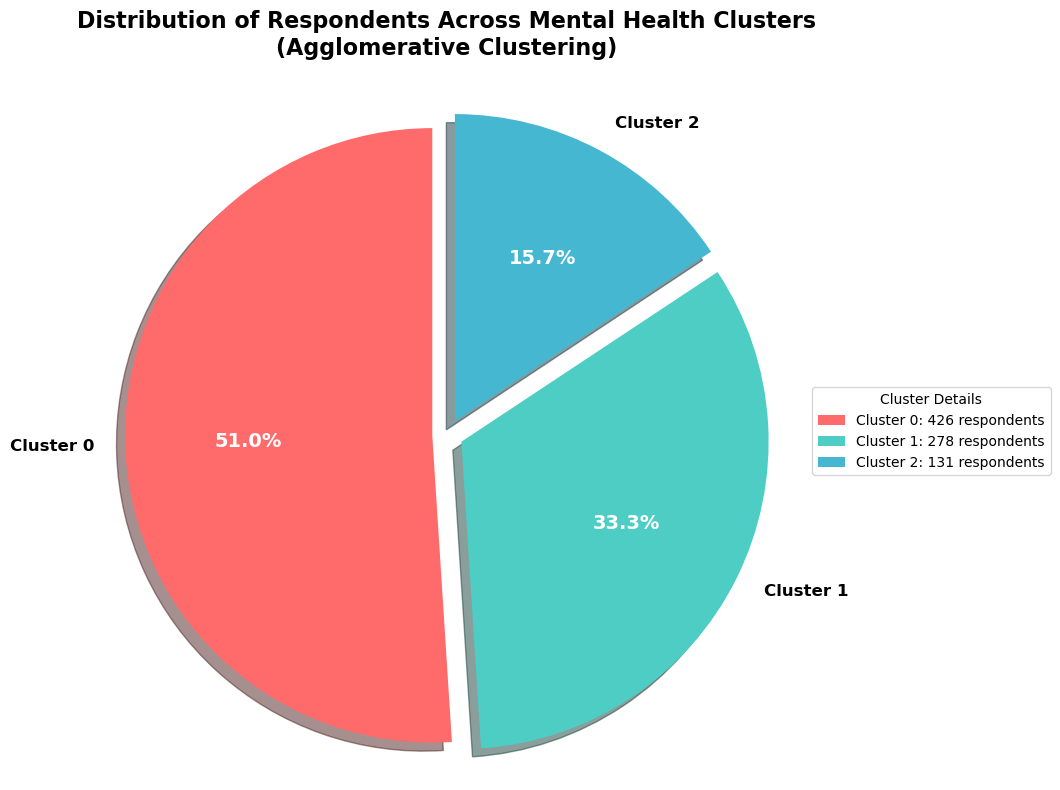


Summary:
Total respondents: 835
Number of clusters: 3
Largest cluster: Cluster 0 (426 respondents)
Smallest cluster: Cluster 2 (131 respondents)


In [16]:
# Cluster Distribution Visualization

# Create pie chart showing cluster distribution
print("CLUSTER DISTRIBUTION ANALYSIS")
print("="*35)

# Get cluster counts and percentages
cluster_counts = pd.Series(best_labels).value_counts().sort_index()
cluster_percentages = (cluster_counts / len(best_labels)) * 100

# Display cluster statistics
print("Cluster Distribution:")
for cluster_id, count in cluster_counts.items():
    percentage = cluster_percentages[cluster_id]
    print(f"Cluster {cluster_id}: {count:3d} samples ({percentage:5.1f}%)")

# Create the pie chart
plt.figure(figsize=(10, 8))

# Define colors for the clusters
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Create pie chart with enhanced styling
wedges, texts, autotexts = plt.pie(
    cluster_counts.values, 
    labels=[f'Cluster {i}' for i in cluster_counts.index],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=(0.05, 0.05, 0.05),  # Slightly separate the slices
    shadow=True,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

# Enhance the appearance
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

# Add title and additional information
plt.title('Distribution of Respondents Across Mental Health Clusters\n(Agglomerative Clustering)', 
          fontsize=16, fontweight='bold', pad=20)

# Add sample counts to the legend
legend_labels = [f'Cluster {i}: {count} respondents' 
                for i, count in enumerate(cluster_counts.values)]
plt.legend(wedges, legend_labels, title="Cluster Details", 
          loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary:")
print(f"Total respondents: {len(best_labels):,}")
print(f"Number of clusters: {len(cluster_counts)}")
print(f"Largest cluster: Cluster {cluster_counts.idxmax()} ({cluster_counts.max()} respondents)")
print(f"Smallest cluster: Cluster {cluster_counts.idxmin()} ({cluster_counts.min()} respondents)")

### Cluster 0

This section provides comprehensive profiling of Cluster 0 by analyzing the original categorical data for respondents assigned to this cluster. It creates detailed visualizations and statistical breakdowns of demographics (age, gender), company characteristics (size, tech industry), mental health benefits knowledge, and personal mental health status (disorders, treatment history) to understand what defines this specific segment of the mental health survey population.

LOADING ORIGINAL DATA
✅ Loaded original data: (835, 43)
✅ Added cluster labels to original data
✅ Cluster 0 sample size: 426 respondents

CLUSTER 0 FEATURE ANALYSIS
Age Groups:
  18-25: 53 (12.4%)
  25-45: 335 (78.6%)
  45-80: 38 (8.9%)

Gender Distribution:
  Male: 273 (64.1%)
  Female: 142 (33.3%)
  Other: 11 (2.6%)

Company Size:
  1-5: 15 (3.5%)
  6-25: 65 (15.3%)
  26-100: 110 (25.8%)
  100-500: 101 (23.7%)
  500-1000: 25 (5.9%)
  More than 1000: 110 (25.8%)

Tech Company:
  Yes: 325 (76.3%)
  No: 101 (23.7%)

MH Coverage Knowledge:
  Yes: 209 (49.1%)
  No: 95 (22.3%)
  I am not sure: 122 (28.6%)

MH Benefits Available:
  Yes: 293 (68.8%)
  No: 39 (9.2%)
  I don't know: 81 (19.0%)
  Not eligible for coverage / N/A: 13 (3.1%)



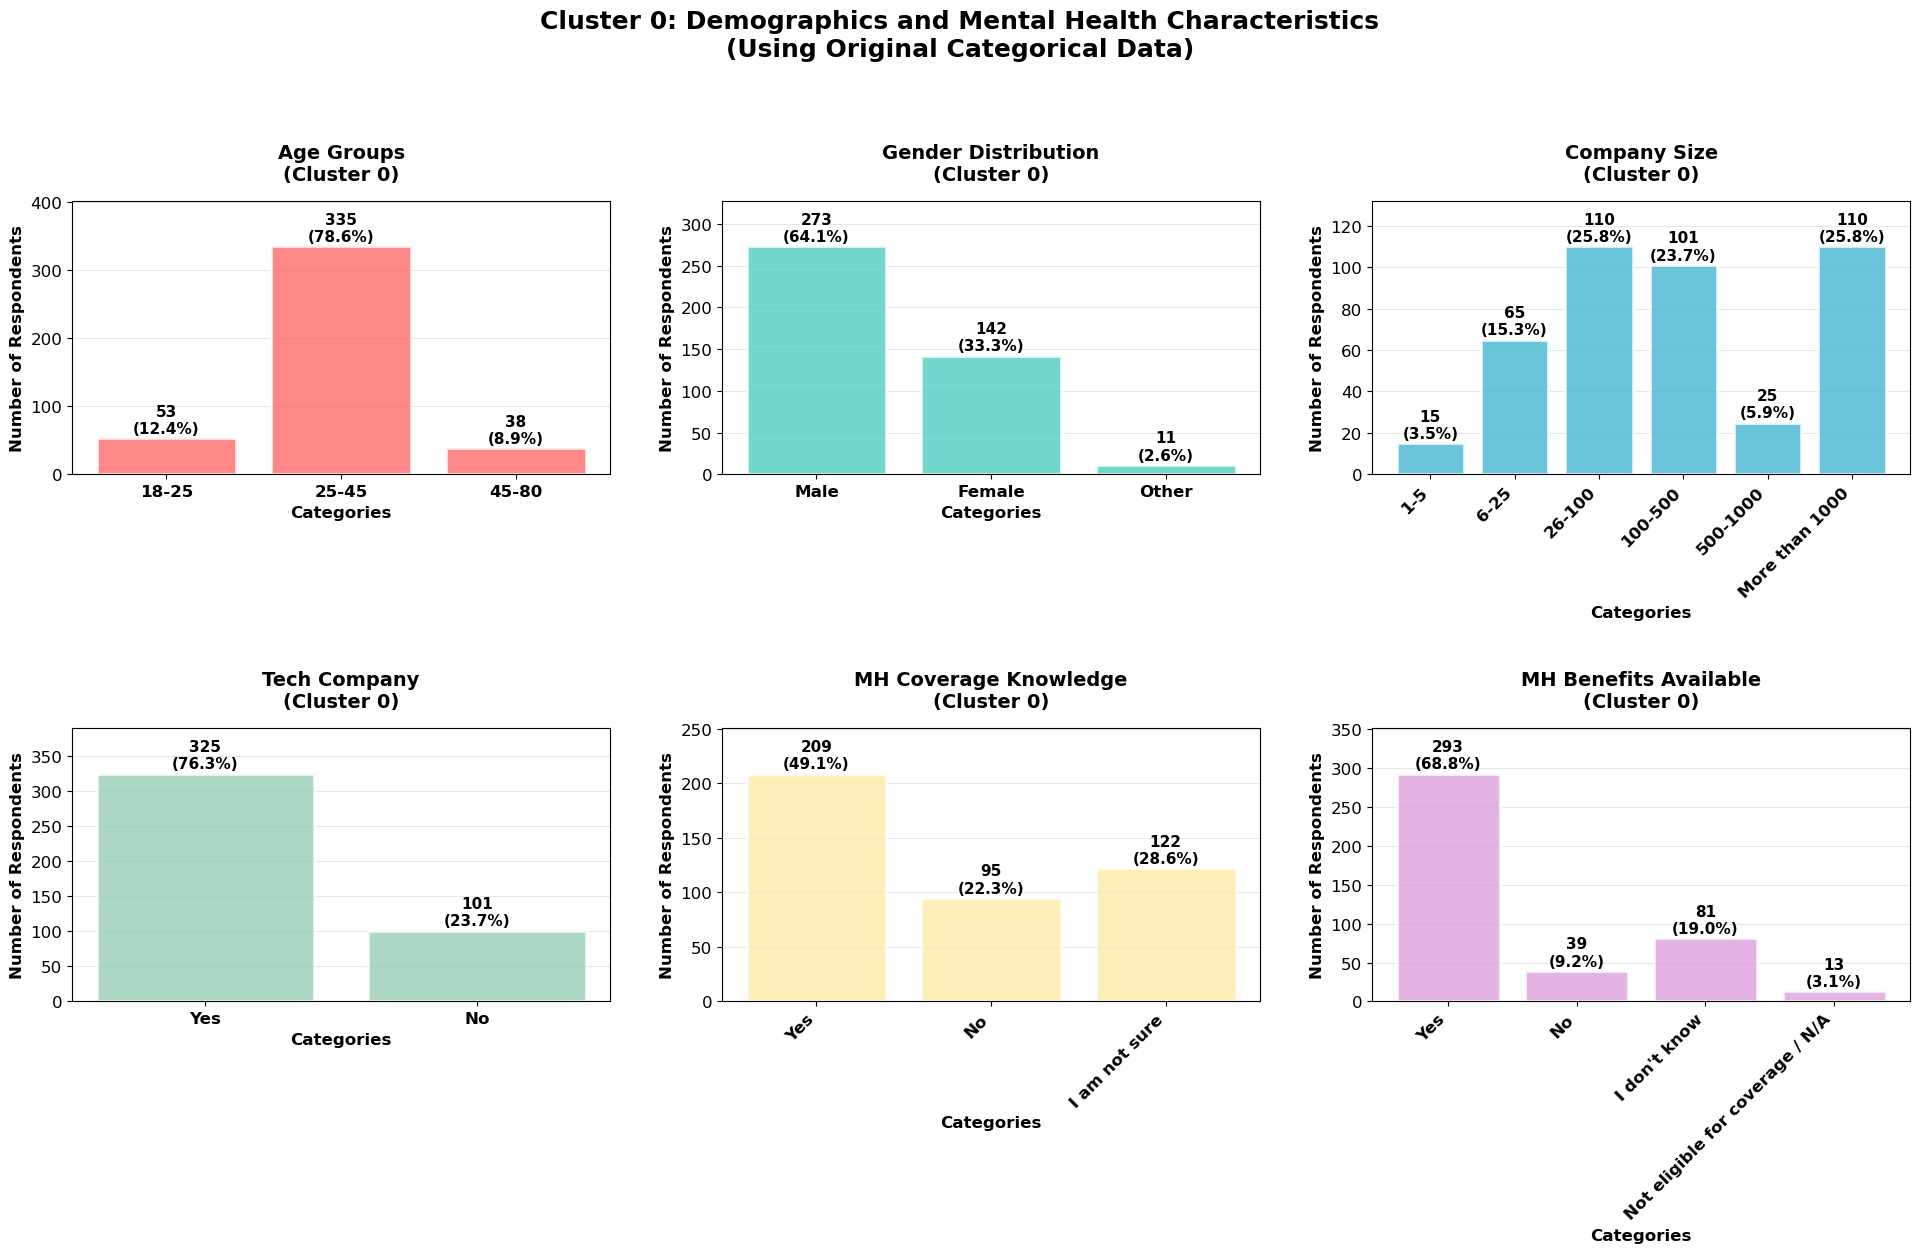

CLUSTER 0 SUMMARY
Total respondents in Cluster 0: 426
Percentage of total sample: 51.0%
Features analyzed: 6


In [34]:
# Cluster 0 Analysis 

# Load the original unscaled data from Excel file
print("LOADING ORIGINAL DATA")
print("="*35)

# Read the Excel file with original categorical data
df_original = pd.read_excel('mental_health_features_cleaned.xlsx')
print(f"✅ Loaded original data: {df_original.shape}")

# Add cluster labels from the scaled data to the original data
# Make sure the order matches
df_original['cluster'] = df_clustered['cluster'].values
print(f"✅ Added cluster labels to original data")

# Filter for Cluster 0 only
cluster_0_original = df_original[df_original['cluster'] == 0].copy()
cluster_0_size = len(cluster_0_original)

print(f"✅ Cluster 0 sample size: {cluster_0_size} respondents")
print()

# Prepare age groups from the actual age values
cluster_0_original['age_group'] = pd.cut(cluster_0_original['age_clean'], 
                                       bins=[18, 25, 45, 80], 
                                       labels=['18-25', '25-45', '45-80'], 
                                       include_lowest=True)

# Define the features to analyze
features_config = [
    {'column': 'age_group', 'title': 'Age Groups'},
    {'column': 'gender_clean', 'title': 'Gender Distribution'}, 
    {'column': 'company_size', 'title': 'Company Size'},
    {'column': 'is_tech_company', 'title': 'Tech Company'},
    {'column': 'mh_coverage_knowledge', 'title': 'MH Coverage Knowledge'},
    {'column': 'mh_benefits', 'title': 'MH Benefits Available'}
]

# Create a 2x3 subplot layout
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# Color palette
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']

print("CLUSTER 0 FEATURE ANALYSIS")
print("="*35)

# Create bar charts for each feature
for i, feature_config in enumerate(features_config):
    
    column = feature_config['column']
    title = feature_config['title']
    
    # Check if column exists
    if column in cluster_0_original.columns:
        # Get value counts
        value_counts = cluster_0_original[column].value_counts()
        
        # Remove any NaN values
        value_counts = value_counts.dropna()
        
        # Check if we have valid data
        if len(value_counts) == 0:
            axes[i].text(0.5, 0.5, f'No valid data for\n"{title}"', 
                        ha='center', va='center', transform=axes[i].transAxes,
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
            axes[i].set_title(f'{title}\n(No Data)', fontsize=14, fontweight='bold')
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            continue
        
        # Special sorting for specific features
        if column == 'company_size':
            # Sort company sizes by logical order
            size_order = ["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"]
            # Only include sizes that exist in the data
            existing_sizes = [size for size in size_order if size in value_counts.index]
            if existing_sizes:
                value_counts = value_counts.reindex(existing_sizes)
        elif column == 'age_group':
            # Sort age groups by logical order
            age_order = ["18-25", "25-45", "45-80"]
            existing_ages = [age for age in age_order if age in value_counts.index]
            if existing_ages:
                value_counts = value_counts.reindex(existing_ages)
        elif column == 'mh_coverage_knowledge':
            # Sort knowledge responses logically
            knowledge_order = ["Yes", "No", "I am not sure"]
            existing_knowledge = [resp for resp in knowledge_order if resp in value_counts.index]
            if existing_knowledge:
                value_counts = value_counts.reindex(existing_knowledge)
        elif column == 'mh_benefits':
            # Sort benefits responses logically
            benefits_order = ["Yes", "No", "I don't know", "Not eligible for coverage / N/A"]
            existing_benefits = [resp for resp in benefits_order if resp in value_counts.index]
            if existing_benefits:
                value_counts = value_counts.reindex(existing_benefits)
        elif column == 'is_tech_company':
            # Convert 0/1 to No/Yes for display
            tech_map = {0: "No", 1: "Yes"}
            value_counts.index = value_counts.index.map(lambda x: tech_map.get(x, str(x)))
        
        # Remove any NaN values after reindexing
        value_counts = value_counts.dropna()
        
        # Final check
        if len(value_counts) == 0:
            axes[i].text(0.5, 0.5, f'No valid data for\n"{title}" after processing', 
                        ha='center', va='center', transform=axes[i].transAxes,
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
            axes[i].set_title(f'{title}\n(No Data)', fontsize=14, fontweight='bold')
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            continue
        
        # Calculate percentages
        percentages = (value_counts / cluster_0_size) * 100
        
        # Create bar chart
        bars = axes[i].bar(range(len(value_counts)), value_counts.values, 
                          color=colors[i], alpha=0.8, edgecolor='white', linewidth=2)
        
        # Customize the chart
        axes[i].set_title(f'{title}\n(Cluster 0)', 
                         fontsize=14, fontweight='bold', pad=15)
        axes[i].set_xlabel('Categories', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Number of Respondents', fontsize=12, fontweight='bold')
        
        # Set x-axis labels with better formatting
        axes[i].set_xticks(range(len(value_counts)))
        
        # Determine rotation based on label length
        max_label_length = max(len(str(label)) for label in value_counts.index) if len(value_counts.index) > 0 else 0
        rotation = 0 if max_label_length < 10 else 45
        ha_alignment = 'center' if max_label_length < 10 else 'right'
        
        axes[i].set_xticklabels(value_counts.index, rotation=rotation, 
                               ha=ha_alignment, fontweight='bold')
        
        # Add value labels on top of bars
        for j, (bar, count, pct) in enumerate(zip(bars, value_counts.values, percentages.values)):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(value_counts.values) * 0.01,
                        f'{count}\n({pct:.1f}%)', 
                        ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # Add grid for better readability
        axes[i].grid(True, alpha=0.3, axis='y')
        axes[i].set_axisbelow(True)
        
        # Adjust y-axis to accommodate labels
        max_height = max(value_counts.values)
        axes[i].set_ylim(0, max_height * 1.2)
        
        # Print summary for this feature
        print(f"{title}:")
        for idx, count in value_counts.items():
            pct = (count / cluster_0_size) * 100
            print(f"  {idx}: {count} ({pct:.1f}%)")
        print()
        
    else:
        # If feature doesn't exist, show a message
        axes[i].text(0.5, 0.5, f'Column "{column}"\nnot found in dataset', 
                    ha='center', va='center', transform=axes[i].transAxes,
                    fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[i].set_title(f'{title}\n(Not Available)', 
                         fontsize=14, fontweight='bold')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# Adjust layout for better spacing
plt.tight_layout(pad=3.0)

# Add a main title for the entire figure
fig.suptitle('Cluster 0: Demographics and Mental Health Characteristics\n(Using Original Categorical Data)', 
             fontsize=18, fontweight='bold', y=1.07)
plt.savefig('cluster0_first.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics for Cluster 0
print("CLUSTER 0 SUMMARY")
print("="*25)
print(f"Total respondents in Cluster 0: {cluster_0_size}")
print(f"Percentage of total sample: {(cluster_0_size/len(df_original))*100:.1f}%")
print(f"Features analyzed: {len(features_config)}")

CLUSTER 0 MENTAL HEALTH VARIABLES ANALYSIS
Cluster 0 sample size: 426 respondents

Past Mental Health Disorder:
  Yes: 376 (88.3%)
  No: 23 (5.4%)

Current Mental Health Disorder:
  Yes: 310 (72.8%)
  No: 47 (11.0%)

Professionally Diagnosed:
  Yes: 377 (88.5%)
  No: 49 (11.5%)

Sought Treatment:
  Yes: 405 (95.1%)
  No: 21 (4.9%)

Work Interference (Treated):
  Never: 53 (12.4%)
  Rarely: 161 (37.8%)
  Sometimes: 163 (38.3%)
  Often: 26 (6.1%)
  Not applicable to me: 23 (5.4%)

Work Interference (Untreated):
  Never: 2 (0.5%)
  Rarely: 17 (4.0%)
  Sometimes: 129 (30.3%)
  Often: 263 (61.7%)
  Not applicable to me: 15 (3.5%)



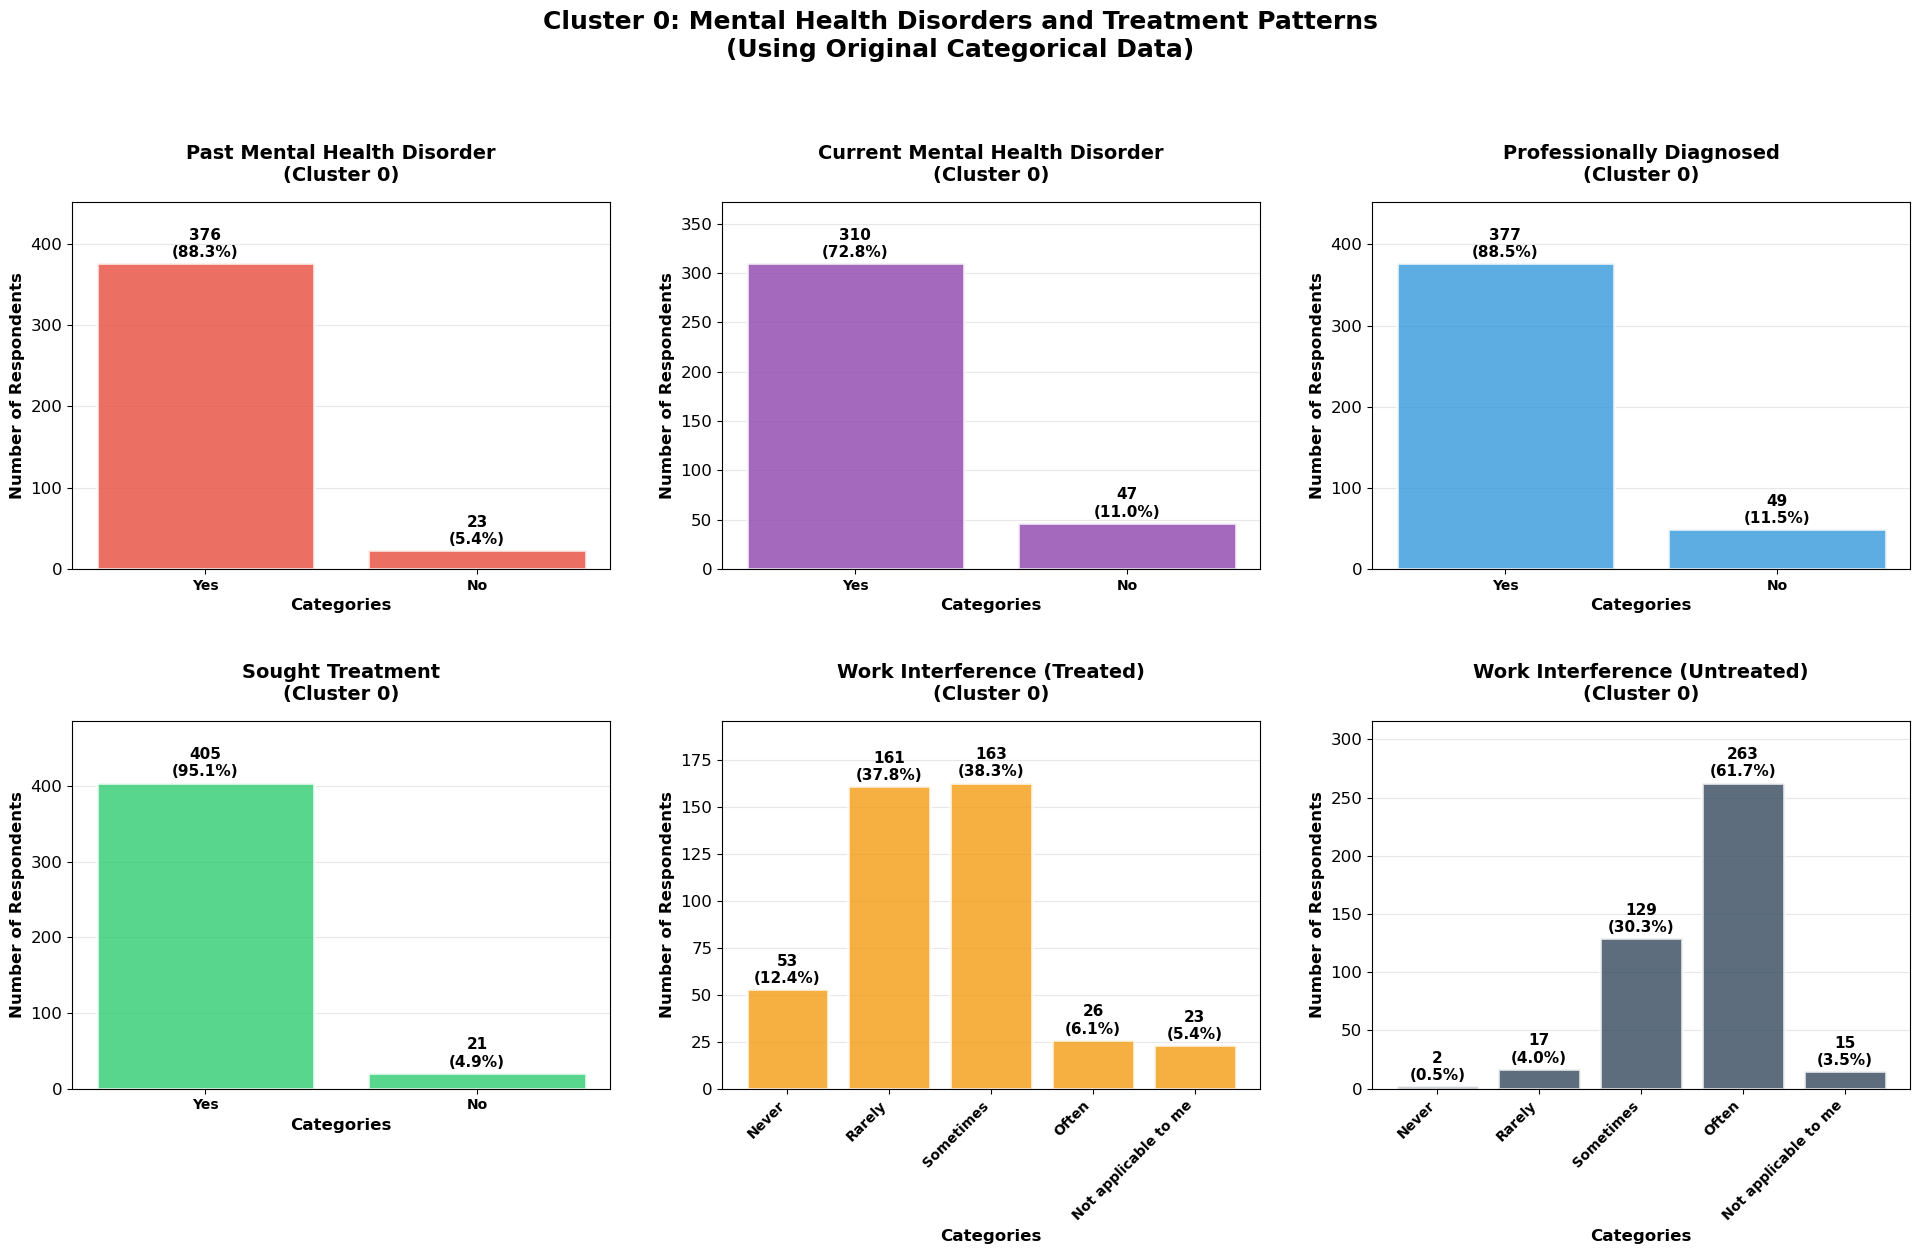

CLUSTER 0 MENTAL HEALTH SUMMARY
Past MH disorder: 376/426 (88.3%)
Current MH disorder: 310/426 (72.8%)
Sought treatment: 405/426 (95.1%)

Total respondents analyzed: 426


In [33]:
# Cluster 0 Analysis

print("CLUSTER 0 MENTAL HEALTH VARIABLES ANALYSIS")
print("="*45)
print(f"Cluster 0 sample size: {cluster_0_size} respondents")
print()

# Define the mental health features to analyze
mh_features_config = [
    {'column': 'past_mh_disorder', 'title': 'Past Mental Health Disorder'},
    {'column': 'current_mh_disorder', 'title': 'Current Mental Health Disorder'}, 
    {'column': 'professionally_diagnosed', 'title': 'Professionally Diagnosed'},
    {'column': 'sought_treatment', 'title': 'Sought Treatment'},
    {'column': 'work_interference_treated', 'title': 'Work Interference (Treated)'},
    {'column': 'work_interference_untreated', 'title': 'Work Interference (Untreated)'}
]

# Create a 2x3 subplot layout for mental health variables
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# Different color palette for mental health variables
mh_colors = ['#E74C3C', '#8E44AD', '#3498DB', '#2ECC71', '#F39C12', '#34495E']

# Create bar charts for each mental health feature
for i, feature_config in enumerate(mh_features_config):
    
    column = feature_config['column']
    title = feature_config['title']
    
    # Check if column exists
    if column in cluster_0_original.columns:
        # Handle the sought_treatment column which might be 0/1
        if column == 'sought_treatment':
            # Convert 0/1 to No/Yes for display
            cluster_0_display = cluster_0_original.copy()
            treatment_map = {0: "No", 1: "Yes"}
            cluster_0_display[column] = cluster_0_original[column].map(lambda x: treatment_map.get(x, str(x)))
            value_counts = cluster_0_display[column].value_counts()
        else:
            # Get value counts for other columns
            value_counts = cluster_0_original[column].value_counts()
        
        # Remove any NaN values
        value_counts = value_counts.dropna()
        
        # Check if we have valid data
        if len(value_counts) == 0:
            axes[i].text(0.5, 0.5, f'No valid data for\n"{title}"', 
                        ha='center', va='center', transform=axes[i].transAxes,
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
            axes[i].set_title(f'{title}\n(No Data)', fontsize=14, fontweight='bold')
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            continue
        
        # Special sorting for specific features
        if column in ['past_mh_disorder', 'current_mh_disorder', 'professionally_diagnosed', 'sought_treatment']:
            # Sort Yes/No responses with Yes first
            yn_order = ["Yes", "No"]
            existing_yn = [resp for resp in yn_order if resp in value_counts.index]
            if existing_yn:
                value_counts = value_counts.reindex(existing_yn)
        elif column in ['work_interference_treated', 'work_interference_untreated']:
            # Sort work interference responses logically
            interference_order = ["Never", "Rarely", "Sometimes", "Often", "Not applicable to me"]
            existing_interference = [resp for resp in interference_order if resp in value_counts.index]
            if existing_interference:
                value_counts = value_counts.reindex(existing_interference)
        
        # Remove any NaN values after reindexing
        value_counts = value_counts.dropna()
        
        # Final check
        if len(value_counts) == 0:
            axes[i].text(0.5, 0.5, f'No valid data for\n"{title}" after processing', 
                        ha='center', va='center', transform=axes[i].transAxes,
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
            axes[i].set_title(f'{title}\n(No Data)', fontsize=14, fontweight='bold')
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            continue
        
        # Calculate percentages
        percentages = (value_counts / cluster_0_size) * 100
        
        # Create bar chart
        bars = axes[i].bar(range(len(value_counts)), value_counts.values, 
                          color=mh_colors[i], alpha=0.8, edgecolor='white', linewidth=2)
        
        # Customize the chart
        axes[i].set_title(f'{title}\n(Cluster 0)', 
                         fontsize=14, fontweight='bold', pad=15)
        axes[i].set_xlabel('Categories', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Number of Respondents', fontsize=12, fontweight='bold')
        
        # Set x-axis labels with better formatting
        axes[i].set_xticks(range(len(value_counts)))
        
        # Determine rotation based on label length
        max_label_length = max(len(str(label)) for label in value_counts.index) if len(value_counts.index) > 0 else 0
        rotation = 0 if max_label_length < 12 else 45
        ha_alignment = 'center' if max_label_length < 12 else 'right'
        
        axes[i].set_xticklabels(value_counts.index, rotation=rotation, 
                               ha=ha_alignment, fontweight='bold', fontsize=10)
        
        # Add value labels on top of bars
        for j, (bar, count, pct) in enumerate(zip(bars, value_counts.values, percentages.values)):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(value_counts.values) * 0.01,
                        f'{count}\n({pct:.1f}%)', 
                        ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # Add grid for better readability
        axes[i].grid(True, alpha=0.3, axis='y')
        axes[i].set_axisbelow(True)
        
        # Adjust y-axis to accommodate labels
        max_height = max(value_counts.values)
        axes[i].set_ylim(0, max_height * 1.2)
        
        # Print summary for this feature
        print(f"{title}:")
        for idx, count in value_counts.items():
            pct = (count / cluster_0_size) * 100
            print(f"  {idx}: {count} ({pct:.1f}%)")
        print()
        
    else:
        # If feature doesn't exist, show a message
        axes[i].text(0.5, 0.5, f'Column "{column}"\nnot found in dataset', 
                    ha='center', va='center', transform=axes[i].transAxes,
                    fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[i].set_title(f'{title}\n(Not Available)', 
                         fontsize=14, fontweight='bold')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# Adjust layout for better spacing
plt.tight_layout(pad=3.0)

# Add a main title for the entire figure
fig.suptitle('Cluster 0: Mental Health Disorders and Treatment Patterns\n(Using Original Categorical Data)', 
             fontsize=18, fontweight='bold', y=1.07)
plt.savefig('cluster0_second.png', dpi=300, bbox_inches='tight')

plt.show()

# Additional summary analysis
print("CLUSTER 0 MENTAL HEALTH SUMMARY")
print("="*35)

# Calculate some key mental health statistics for Cluster 0
if 'past_mh_disorder' in cluster_0_original.columns:
    past_mh_yes = (cluster_0_original['past_mh_disorder'] == 'Yes').sum()
    print(f"Past MH disorder: {past_mh_yes}/{cluster_0_size} ({(past_mh_yes/cluster_0_size)*100:.1f}%)")

if 'current_mh_disorder' in cluster_0_original.columns:
    current_mh_yes = (cluster_0_original['current_mh_disorder'] == 'Yes').sum()
    print(f"Current MH disorder: {current_mh_yes}/{cluster_0_size} ({(current_mh_yes/cluster_0_size)*100:.1f}%)")

if 'sought_treatment' in cluster_0_original.columns:
    sought_treatment_yes = (cluster_0_original['sought_treatment'] == 1).sum()
    print(f"Sought treatment: {sought_treatment_yes}/{cluster_0_size} ({(sought_treatment_yes/cluster_0_size)*100:.1f}%)")

print(f"\nTotal respondents analyzed: {cluster_0_size}")

In [19]:
# Cluster 0 Analysis

print("CLUSTER 0 COMPREHENSIVE FEATURE ANALYSIS")
print("="*50)
print(f"Total respondents in Cluster 0: {cluster_0_size}")
print("="*50)
print()

# Define all features to analyze with their display names
all_features = [
    # Demographics
    ('age_group', 'Age Groups'),
    ('gender_clean', 'Gender Distribution'),
    ('self_employed', 'Self Employed'),
    
    # Company Information
    ('company_size', 'Company Size'),
    ('is_tech_company', 'Tech Company'),
    ('work_remotely', 'Work Remotely'),
    
    # Mental Health Benefits & Knowledge
    ('mh_benefits', 'MH Benefits Available'),
    ('mh_coverage_knowledge', 'MH Coverage Knowledge'),
    ('employer_mh_discussion', 'Employer MH Discussion Comfort'),
    ('employer_mh_resources', 'Employer Provides MH Resources'),
    ('anonymity_protected', 'Anonymity Protected'),
    ('leave_difficulty', 'Taking Mental Health Leave Difficulty'),
    ('employer_mh_consequences', 'Employer MH Consequences'),
    ('employer_ph_consequences', 'Employer Physical Health Consequences'),
    
    # Workplace Comfort & Attitudes
    ('coworker_mh_comfort', 'Coworker MH Discussion Comfort'),
    ('supervisor_mh_comfort', 'Supervisor MH Discussion Comfort'),
    ('mh_ph_equality', 'Mental Health = Physical Health Treatment'),
    ('observed_consequences', 'Observed Negative Consequences'),
    
    # Previous Employers (if applicable)
    ('has_prev_employers', 'Has Previous Employers'),
    ('prev_mh_benefits', 'Previous Employers: MH Benefits'),
    ('prev_mh_coverage_knowledge', 'Previous Employers: MH Coverage Knowledge'),
    ('prev_employer_mh_discussion', 'Previous Employers: MH Discussion'),
    ('prev_employer_mh_resources', 'Previous Employers: MH Resources'),
    ('prev_anonymity_protected', 'Previous Employers: Anonymity Protected'),
    ('prev_employer_mh_consequences', 'Previous Employers: MH Consequences'),
    ('prev_employer_ph_consequences', 'Previous Employers: PH Consequences'),
    ('prev_coworker_mh_willingness', 'Previous Employers: Coworker MH Willingness'),
    ('prev_supervisor_mh_willingness', 'Previous Employers: Supervisor MH Willingness'),
    ('prev_mh_ph_equality', 'Previous Employers: MH/PH Equality'),
    ('prev_observed_consequences', 'Previous Employers: Observed Consequences'),
    
    # Interview & Career Impact
    ('interview_ph_discussion', 'Interview: Physical Health Discussion'),
    ('interview_mh_discussion', 'Interview: Mental Health Discussion'),
    ('mh_hurt_career', 'Mental Health Could Hurt Career'),
    ('coworkers_negative_view', 'Coworkers Would View Negatively'),
    
    # Family & Social
    ('family_sharing_willingness', 'Family Sharing Willingness'),
    ('unsupportive_response', 'Experienced Unsupportive Response'),
    ('family_history_mh', 'Family History of Mental Health'),
    
    # Personal Mental Health
    ('past_mh_disorder', 'Past Mental Health Disorder'),
    ('current_mh_disorder', 'Current Mental Health Disorder'),
    ('professionally_diagnosed', 'Professionally Diagnosed'),
    ('sought_treatment', 'Sought Treatment'),
    ('work_interference_treated', 'Work Interference (When Treated)'),
    ('work_interference_untreated', 'Work Interference (When Untreated)')
]

# Function to convert certain binary columns to Yes/No
def convert_binary_to_yesno(series):
    """Convert 0/1 or similar binary values to Yes/No"""
    return series.map({0: "No", 1: "Yes"}).fillna(series)

# Process and display each feature
for column, display_name in all_features:
    if column in cluster_0_original.columns:
        # Special handling for certain columns
        if column in ['self_employed', 'is_tech_company', 'work_remotely', 'has_prev_employers', 
                      'sought_treatment', 'past_mh_disorder', 'current_mh_disorder', 
                      'professionally_diagnosed']:
            # Convert binary to Yes/No for better readability
            data_to_analyze = convert_binary_to_yesno(cluster_0_original[column])
        else:
            data_to_analyze = cluster_0_original[column]
        
        # Get value counts
        value_counts = data_to_analyze.value_counts().dropna()
        
        if len(value_counts) > 0:
            print(f"{display_name}:")
            
            # Sort certain categories logically (but include ALL existing values)
            if column == 'company_size':
                size_order = ["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"]
                # Include existing values in preferred order, plus any others not in the list
                ordered_values = [size for size in size_order if size in value_counts.index]
                other_values = [x for x in value_counts.index if x not in size_order]
                value_counts = value_counts.reindex(ordered_values + other_values)
            elif column == 'age_group':
                age_order = ["18-25", "25-45", "45-80"]
                ordered_values = [age for age in age_order if age in value_counts.index]
                other_values = [x for x in value_counts.index if x not in age_order]
                value_counts = value_counts.reindex(ordered_values + other_values)
            elif 'interference' in column:
                interference_order = ["Never", "Rarely", "Sometimes", "Often", "Not applicable to me"]
                ordered_values = [resp for resp in interference_order if resp in value_counts.index]
                other_values = [x for x in value_counts.index if x not in interference_order]
                value_counts = value_counts.reindex(ordered_values + other_values)
            elif column in ['mh_coverage_knowledge', 'prev_mh_coverage_knowledge']:
                knowledge_order = ["Yes", "No", "I am not sure", "N/A (not currently aware)"]
                ordered_values = [resp for resp in knowledge_order if resp in value_counts.index]
                other_values = [x for x in value_counts.index if x not in knowledge_order]
                value_counts = value_counts.reindex(ordered_values + other_values)
            elif column in ['mh_benefits', 'prev_mh_benefits']:
                benefits_order = ["Yes", "No", "I don't know", "Not eligible for coverage / N/A"]
                ordered_values = [resp for resp in benefits_order if resp in value_counts.index]
                other_values = [x for x in value_counts.index if x not in benefits_order]
                value_counts = value_counts.reindex(ordered_values + other_values)
            elif 'Yes' in value_counts.index and 'No' in value_counts.index:
                # For Yes/No questions, show Yes first
                yn_order = ["Yes", "No"]
                ordered_values = [resp for resp in yn_order if resp in value_counts.index]
                other_values = [x for x in value_counts.index if x not in yn_order]
                value_counts = value_counts.reindex(ordered_values + other_values)
            
            # Remove NaN values after reindexing
            value_counts = value_counts.dropna()
            
            # Display each value with count and percentage
            for value, count in value_counts.items():
                percentage = (count / cluster_0_size) * 100
                print(f"  {value}: {count} ({percentage:.1f}%)")
            
            print()  # Empty line for readability
        else:
            print(f"{display_name}: No valid data")
            print()
    else:
        print(f"{display_name}: Column not found in dataset")
        print()

print("="*50)
print(f"SUMMARY: {cluster_0_size} total respondents analyzed across {len(all_features)} features")
print("="*50)

CLUSTER 0 COMPREHENSIVE FEATURE ANALYSIS
Total respondents in Cluster 0: 426

Age Groups:
  18-25: 53 (12.4%)
  25-45: 335 (78.6%)
  45-80: 38 (8.9%)

Gender Distribution:
  Male: 273 (64.1%)
  Female: 142 (33.3%)
  Other: 11 (2.6%)

Self Employed:
  No: 426 (100.0%)

Company Size:
  1-5: 15 (3.5%)
  6-25: 65 (15.3%)
  26-100: 110 (25.8%)
  100-500: 101 (23.7%)
  500-1000: 25 (5.9%)
  More than 1000: 110 (25.8%)

Tech Company:
  Yes: 325 (76.3%)
  No: 101 (23.7%)

Work Remotely:
  Sometimes: 249 (58.5%)
  Never: 92 (21.6%)
  Always: 85 (20.0%)

MH Benefits Available:
  Yes: 293 (68.8%)
  No: 39 (9.2%)
  I don't know: 81 (19.0%)
  Not eligible for coverage / N/A: 13 (3.1%)

MH Coverage Knowledge:
  Yes: 209 (49.1%)
  No: 95 (22.3%)
  I am not sure: 122 (28.6%)

Employer MH Discussion Comfort:
  Yes: 84 (19.7%)
  No: 307 (72.1%)
  I don't know: 35 (8.2%)

Employer Provides MH Resources:
  Yes: 140 (32.9%)
  No: 166 (39.0%)
  I don't know: 120 (28.2%)

Anonymity Protected:
  Yes: 140 (32.

### Cluster 1

This section provides comprehensive profiling of Cluster 1 by analyzing the original categorical data for respondents in this cluster. It follows the same analytical approach as Cluster 0, creating detailed visualizations and statistical breakdowns of demographics, company characteristics, mental health benefits knowledge, and personal mental health status to identify the distinct characteristics that define this second segment of the mental health survey population.

LOADING ORIGINAL DATA
✅ Loaded original data: (835, 43)
✅ Added cluster labels to original data
✅ Cluster 1 sample size: 278 respondents

CLUSTER 1 FEATURE ANALYSIS
Age Groups:
  18-25: 33 (11.9%)
  25-45: 225 (80.9%)
  45-80: 20 (7.2%)

Gender Distribution:
  Male: 219 (78.8%)
  Female: 56 (20.1%)
  Other: 3 (1.1%)

Company Size:
  1-5: 14 (5.0%)
  6-25: 51 (18.3%)
  26-100: 69 (24.8%)
  100-500: 59 (21.2%)
  500-1000: 21 (7.6%)
  More than 1000: 64 (23.0%)

Tech Company:
  Yes: 210 (75.5%)
  No: 68 (24.5%)

MH Coverage Knowledge:
  Yes: 64 (23.0%)
  No: 114 (41.0%)
  I am not sure: 100 (36.0%)

MH Benefits Available:
  Yes: 130 (46.8%)
  No: 28 (10.1%)
  I don't know: 114 (41.0%)
  Not eligible for coverage / N/A: 6 (2.2%)



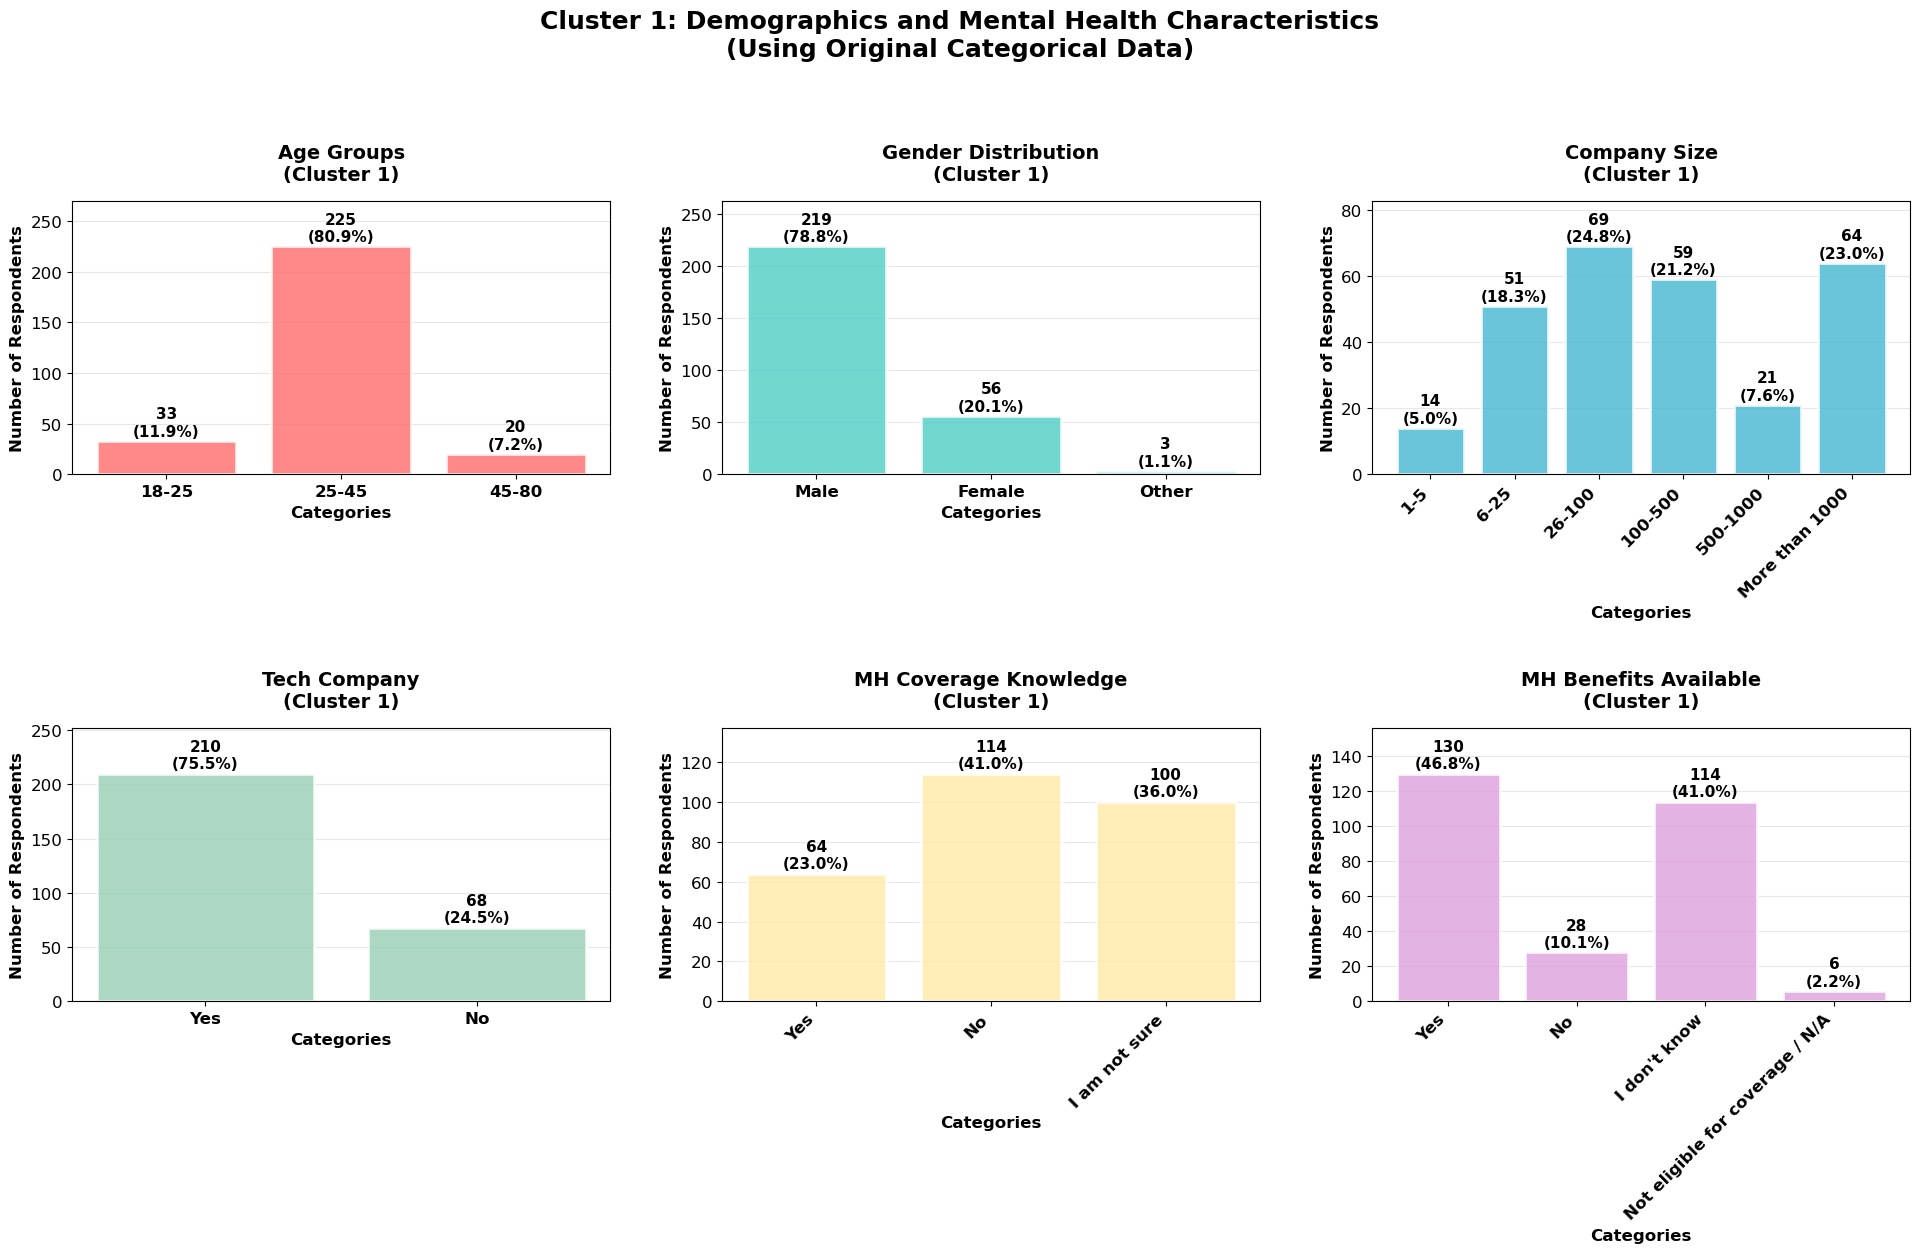

CLUSTER 1 SUMMARY
Total respondents in Cluster 1: 278
Percentage of total sample: 33.3%
Features analyzed: 6


In [32]:
# Cluster 1 Analysis 

# Load the original unscaled data from Excel file
print("LOADING ORIGINAL DATA")
print("="*35)

# Read the Excel file with original categorical data
df_original = pd.read_excel('mental_health_features_cleaned.xlsx')
print(f"✅ Loaded original data: {df_original.shape}")

# Add cluster labels from the scaled data to the original data
# Make sure the order matches
df_original['cluster'] = df_clustered['cluster'].values
print(f"✅ Added cluster labels to original data")

# Filter for Cluster 1 only
cluster_1_original = df_original[df_original['cluster'] == 1].copy()
cluster_1_size = len(cluster_1_original)

print(f"✅ Cluster 1 sample size: {cluster_1_size} respondents")
print()

# Prepare age groups from the actual age values
cluster_1_original['age_group'] = pd.cut(cluster_1_original['age_clean'], 
                                       bins=[18, 25, 45, 80], 
                                       labels=['18-25', '25-45', '45-80'], 
                                       include_lowest=True)

# Define the features to analyze
features_config = [
    {'column': 'age_group', 'title': 'Age Groups'},
    {'column': 'gender_clean', 'title': 'Gender Distribution'}, 
    {'column': 'company_size', 'title': 'Company Size'},
    {'column': 'is_tech_company', 'title': 'Tech Company'},
    {'column': 'mh_coverage_knowledge', 'title': 'MH Coverage Knowledge'},
    {'column': 'mh_benefits', 'title': 'MH Benefits Available'}
]

# Create a 2x3 subplot layout
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# Color palette
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']

print("CLUSTER 1 FEATURE ANALYSIS")
print("="*35)

# Create bar charts for each feature
for i, feature_config in enumerate(features_config):
    
    column = feature_config['column']
    title = feature_config['title']
    
    # Check if column exists
    if column in cluster_1_original.columns:
        # Get value counts
        value_counts = cluster_1_original[column].value_counts()
        
        # Remove any NaN values
        value_counts = value_counts.dropna()
        
        # Check if we have valid data
        if len(value_counts) == 0:
            axes[i].text(0.5, 0.5, f'No valid data for\n"{title}"', 
                        ha='center', va='center', transform=axes[i].transAxes,
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
            axes[i].set_title(f'{title}\n(No Data)', fontsize=14, fontweight='bold')
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            continue
        
        # Special sorting for specific features
        if column == 'company_size':
            # Sort company sizes by logical order
            size_order = ["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"]
            # Only include sizes that exist in the data
            existing_sizes = [size for size in size_order if size in value_counts.index]
            if existing_sizes:
                value_counts = value_counts.reindex(existing_sizes)
        elif column == 'age_group':
            # Sort age groups by logical order
            age_order = ["18-25", "25-45", "45-80"]
            existing_ages = [age for age in age_order if age in value_counts.index]
            if existing_ages:
                value_counts = value_counts.reindex(existing_ages)
        elif column == 'mh_coverage_knowledge':
            # Sort knowledge responses logically
            knowledge_order = ["Yes", "No", "I am not sure"]
            existing_knowledge = [resp for resp in knowledge_order if resp in value_counts.index]
            if existing_knowledge:
                value_counts = value_counts.reindex(existing_knowledge)
        elif column == 'mh_benefits':
            # Sort benefits responses logically
            benefits_order = ["Yes", "No", "I don't know", "Not eligible for coverage / N/A"]
            existing_benefits = [resp for resp in benefits_order if resp in value_counts.index]
            if existing_benefits:
                value_counts = value_counts.reindex(existing_benefits)
        elif column == 'is_tech_company':
            # Convert 0/1 to No/Yes for display
            tech_map = {0: "No", 1: "Yes"}
            value_counts.index = value_counts.index.map(lambda x: tech_map.get(x, str(x)))
        
        # Remove any NaN values after reindexing
        value_counts = value_counts.dropna()
        
        # Final check
        if len(value_counts) == 0:
            axes[i].text(0.5, 0.5, f'No valid data for\n"{title}" after processing', 
                        ha='center', va='center', transform=axes[i].transAxes,
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
            axes[i].set_title(f'{title}\n(No Data)', fontsize=14, fontweight='bold')
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            continue
        
        # Calculate percentages
        percentages = (value_counts / cluster_1_size) * 100
        
        # Create bar chart
        bars = axes[i].bar(range(len(value_counts)), value_counts.values, 
                          color=colors[i], alpha=0.8, edgecolor='white', linewidth=2)
        
        # Customize the chart
        axes[i].set_title(f'{title}\n(Cluster 1)', 
                         fontsize=14, fontweight='bold', pad=15)
        axes[i].set_xlabel('Categories', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Number of Respondents', fontsize=12, fontweight='bold')
        
        # Set x-axis labels with better formatting
        axes[i].set_xticks(range(len(value_counts)))
        
        # Determine rotation based on label length
        max_label_length = max(len(str(label)) for label in value_counts.index) if len(value_counts.index) > 0 else 0
        rotation = 0 if max_label_length < 10 else 45
        ha_alignment = 'center' if max_label_length < 10 else 'right'
        
        axes[i].set_xticklabels(value_counts.index, rotation=rotation, 
                               ha=ha_alignment, fontweight='bold')
        
        # Add value labels on top of bars
        for j, (bar, count, pct) in enumerate(zip(bars, value_counts.values, percentages.values)):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(value_counts.values) * 0.01,
                        f'{count}\n({pct:.1f}%)', 
                        ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # Add grid for better readability
        axes[i].grid(True, alpha=0.3, axis='y')
        axes[i].set_axisbelow(True)
        
        # Adjust y-axis to accommodate labels
        max_height = max(value_counts.values)
        axes[i].set_ylim(0, max_height * 1.2)
        
        # Print summary for this feature
        print(f"{title}:")
        for idx, count in value_counts.items():
            pct = (count / cluster_1_size) * 100
            print(f"  {idx}: {count} ({pct:.1f}%)")
        print()
        
    else:
        # If feature doesn't exist, show a message
        axes[i].text(0.5, 0.5, f'Column "{column}"\nnot found in dataset', 
                    ha='center', va='center', transform=axes[i].transAxes,
                    fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[i].set_title(f'{title}\n(Not Available)', 
                         fontsize=14, fontweight='bold')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# Adjust layout for better spacing
plt.tight_layout(pad=3.0)

# Add a main title for the entire figure
fig.suptitle('Cluster 1: Demographics and Mental Health Characteristics\n(Using Original Categorical Data)', 
             fontsize=18, fontweight='bold', y=1.07)
plt.savefig('cluster1_first.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics for Cluster 1
print("CLUSTER 1 SUMMARY")
print("="*25)
print(f"Total respondents in Cluster 1: {cluster_1_size}")
print(f"Percentage of total sample: {(cluster_1_size/len(df_original))*100:.1f}%")
print(f"Features analyzed: {len(features_config)}")


CLUSTER 1 MENTAL HEALTH VARIABLES ANALYSIS
Cluster 1 sample size: 278 respondents

Past Mental Health Disorder:
  Yes: 21 (7.6%)
  No: 173 (62.2%)

Current Mental Health Disorder:
  Yes: 14 (5.0%)
  No: 184 (66.2%)

Professionally Diagnosed:
  Yes: 14 (5.0%)
  No: 264 (95.0%)

Sought Treatment:
  Yes: 46 (16.5%)
  No: 232 (83.5%)

Work Interference (Treated):
  Never: 15 (5.4%)
  Rarely: 19 (6.8%)
  Sometimes: 17 (6.1%)
  Often: 1 (0.4%)
  Not applicable to me: 226 (81.3%)

Work Interference (Untreated):
  Never: 2 (0.7%)
  Rarely: 9 (3.2%)
  Sometimes: 50 (18.0%)
  Often: 25 (9.0%)
  Not applicable to me: 192 (69.1%)



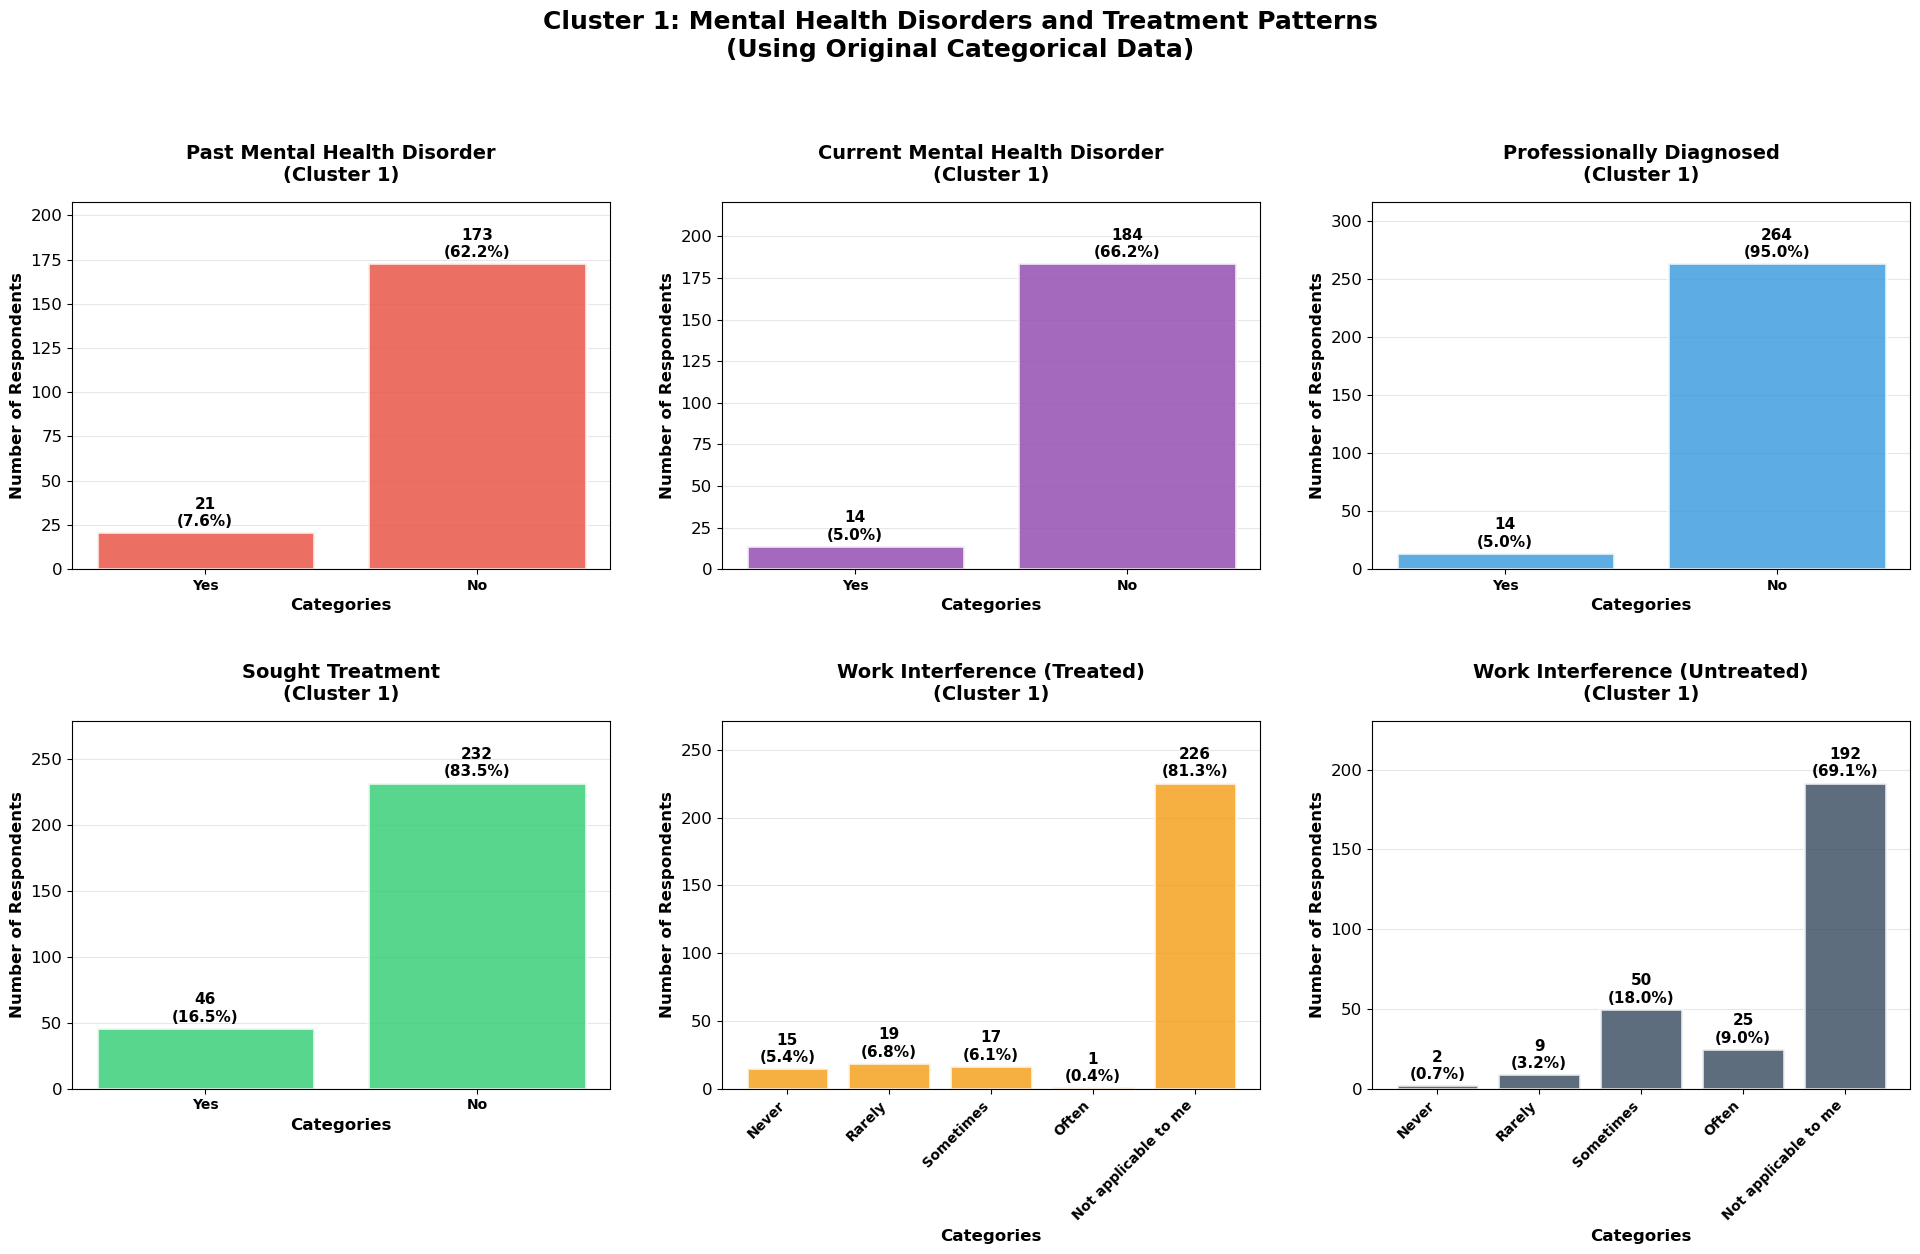

CLUSTER 1 MENTAL HEALTH SUMMARY
Past MH disorder: 21/278 (7.6%)
Current MH disorder: 14/278 (5.0%)
Sought treatment: 46/278 (16.5%)

Total respondents analyzed: 278


In [31]:
# Cluster 1 Analysis

print("\nCLUSTER 1 MENTAL HEALTH VARIABLES ANALYSIS")
print("="*45)
print(f"Cluster 1 sample size: {cluster_1_size} respondents")
print()

# Define the mental health features to analyze
mh_features_config = [
    {'column': 'past_mh_disorder', 'title': 'Past Mental Health Disorder'},
    {'column': 'current_mh_disorder', 'title': 'Current Mental Health Disorder'}, 
    {'column': 'professionally_diagnosed', 'title': 'Professionally Diagnosed'},
    {'column': 'sought_treatment', 'title': 'Sought Treatment'},
    {'column': 'work_interference_treated', 'title': 'Work Interference (Treated)'},
    {'column': 'work_interference_untreated', 'title': 'Work Interference (Untreated)'}
]

# Create a 2x3 subplot layout for mental health variables
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# Different color palette for mental health variables
mh_colors = ['#E74C3C', '#8E44AD', '#3498DB', '#2ECC71', '#F39C12', '#34495E']

# Create bar charts for each mental health feature
for i, feature_config in enumerate(mh_features_config):
    
    column = feature_config['column']
    title = feature_config['title']
    
    # Check if column exists
    if column in cluster_1_original.columns:
        # Handle the sought_treatment column which might be 0/1
        if column == 'sought_treatment':
            # Convert 0/1 to No/Yes for display
            cluster_1_display = cluster_1_original.copy()
            treatment_map = {0: "No", 1: "Yes"}
            cluster_1_display[column] = cluster_1_original[column].map(lambda x: treatment_map.get(x, str(x)))
            value_counts = cluster_1_display[column].value_counts()
        else:
            # Get value counts for other columns
            value_counts = cluster_1_original[column].value_counts()
        
        # Remove any NaN values
        value_counts = value_counts.dropna()
        
        # Check if we have valid data
        if len(value_counts) == 0:
            axes[i].text(0.5, 0.5, f'No valid data for\n"{title}"', 
                        ha='center', va='center', transform=axes[i].transAxes,
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
            axes[i].set_title(f'{title}\n(No Data)', fontsize=14, fontweight='bold')
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            continue
        
        # Special sorting for specific features
        if column in ['past_mh_disorder', 'current_mh_disorder', 'professionally_diagnosed', 'sought_treatment']:
            # Sort Yes/No responses with Yes first
            yn_order = ["Yes", "No"]
            existing_yn = [resp for resp in yn_order if resp in value_counts.index]
            if existing_yn:
                value_counts = value_counts.reindex(existing_yn)
        elif column in ['work_interference_treated', 'work_interference_untreated']:
            # Sort work interference responses logically
            interference_order = ["Never", "Rarely", "Sometimes", "Often", "Not applicable to me"]
            existing_interference = [resp for resp in interference_order if resp in value_counts.index]
            if existing_interference:
                value_counts = value_counts.reindex(existing_interference)
        
        # Remove any NaN values after reindexing
        value_counts = value_counts.dropna()
        
        # Final check
        if len(value_counts) == 0:
            axes[i].text(0.5, 0.5, f'No valid data for\n"{title}" after processing', 
                        ha='center', va='center', transform=axes[i].transAxes,
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
            axes[i].set_title(f'{title}\n(No Data)', fontsize=14, fontweight='bold')
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            continue
        
        # Calculate percentages
        percentages = (value_counts / cluster_1_size) * 100
        
        # Create bar chart
        bars = axes[i].bar(range(len(value_counts)), value_counts.values, 
                          color=mh_colors[i], alpha=0.8, edgecolor='white', linewidth=2)
        
        # Customize the chart
        axes[i].set_title(f'{title}\n(Cluster 1)', 
                         fontsize=14, fontweight='bold', pad=15)
        axes[i].set_xlabel('Categories', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Number of Respondents', fontsize=12, fontweight='bold')
        
        # Set x-axis labels with better formatting
        axes[i].set_xticks(range(len(value_counts)))
        
        # Determine rotation based on label length
        max_label_length = max(len(str(label)) for label in value_counts.index) if len(value_counts.index) > 0 else 0
        rotation = 0 if max_label_length < 12 else 45
        ha_alignment = 'center' if max_label_length < 12 else 'right'
        
        axes[i].set_xticklabels(value_counts.index, rotation=rotation, 
                               ha=ha_alignment, fontweight='bold', fontsize=10)
        
        # Add value labels on top of bars
        for j, (bar, count, pct) in enumerate(zip(bars, value_counts.values, percentages.values)):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(value_counts.values) * 0.01,
                        f'{count}\n({pct:.1f}%)', 
                        ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # Add grid for better readability
        axes[i].grid(True, alpha=0.3, axis='y')
        axes[i].set_axisbelow(True)
        
        # Adjust y-axis to accommodate labels
        max_height = max(value_counts.values)
        axes[i].set_ylim(0, max_height * 1.2)
        
        # Print summary for this feature
        print(f"{title}:")
        for idx, count in value_counts.items():
            pct = (count / cluster_1_size) * 100
            print(f"  {idx}: {count} ({pct:.1f}%)")
        print()
        
    else:
        # If feature doesn't exist, show a message
        axes[i].text(0.5, 0.5, f'Column "{column}"\nnot found in dataset', 
                    ha='center', va='center', transform=axes[i].transAxes,
                    fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[i].set_title(f'{title}\n(Not Available)', 
                         fontsize=14, fontweight='bold')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# Adjust layout for better spacing
plt.tight_layout(pad=3.0)

# Add a main title for the entire figure
fig.suptitle('Cluster 1: Mental Health Disorders and Treatment Patterns\n(Using Original Categorical Data)', 
             fontsize=18, fontweight='bold', y=1.07)
plt.savefig('cluster1_second.png', dpi=300, bbox_inches='tight')

plt.show()

# Additional summary analysis
print("CLUSTER 1 MENTAL HEALTH SUMMARY")
print("="*35)

# Calculate some key mental health statistics for Cluster 1
if 'past_mh_disorder' in cluster_1_original.columns:
    past_mh_yes = (cluster_1_original['past_mh_disorder'] == 'Yes').sum()
    print(f"Past MH disorder: {past_mh_yes}/{cluster_1_size} ({(past_mh_yes/cluster_1_size)*100:.1f}%)")

if 'current_mh_disorder' in cluster_1_original.columns:
    current_mh_yes = (cluster_1_original['current_mh_disorder'] == 'Yes').sum()
    print(f"Current MH disorder: {current_mh_yes}/{cluster_1_size} ({(current_mh_yes/cluster_1_size)*100:.1f}%)")

if 'sought_treatment' in cluster_1_original.columns:
    sought_treatment_yes = (cluster_1_original['sought_treatment'] == 1).sum()
    print(f"Sought treatment: {sought_treatment_yes}/{cluster_1_size} ({(sought_treatment_yes/cluster_1_size)*100:.1f}%)")

print(f"\nTotal respondents analyzed: {cluster_1_size}")

In [22]:
# Cluster 1 Analysis

print("\nCLUSTER 1 COMPREHENSIVE FEATURE ANALYSIS")
print("="*50)
print(f"Total respondents in Cluster 1: {cluster_1_size}")
print("="*50)
print()

# Define all features to analyze with their display names
all_features = [
    # Demographics
    ('age_group', 'Age Groups'),
    ('gender_clean', 'Gender Distribution'),
    ('self_employed', 'Self Employed'),
    
    # Company Information
    ('company_size', 'Company Size'),
    ('is_tech_company', 'Tech Company'),
    ('work_remotely', 'Work Remotely'),
    
    # Mental Health Benefits & Knowledge
    ('mh_benefits', 'MH Benefits Available'),
    ('mh_coverage_knowledge', 'MH Coverage Knowledge'),
    ('employer_mh_discussion', 'Employer MH Discussion Comfort'),
    ('employer_mh_resources', 'Employer Provides MH Resources'),
    ('anonymity_protected', 'Anonymity Protected'),
    ('leave_difficulty', 'Taking Mental Health Leave Difficulty'),
    ('employer_mh_consequences', 'Employer MH Consequences'),
    ('employer_ph_consequences', 'Employer Physical Health Consequences'),
    
    # Workplace Comfort & Attitudes
    ('coworker_mh_comfort', 'Coworker MH Discussion Comfort'),
    ('supervisor_mh_comfort', 'Supervisor MH Discussion Comfort'),
    ('mh_ph_equality', 'Mental Health = Physical Health Treatment'),
    ('observed_consequences', 'Observed Negative Consequences'),
    
    # Previous Employers (if applicable)
    ('has_prev_employers', 'Has Previous Employers'),
    ('prev_mh_benefits', 'Previous Employers: MH Benefits'),
    ('prev_mh_coverage_knowledge', 'Previous Employers: MH Coverage Knowledge'),
    ('prev_employer_mh_discussion', 'Previous Employers: MH Discussion'),
    ('prev_employer_mh_resources', 'Previous Employers: MH Resources'),
    ('prev_anonymity_protected', 'Previous Employers: Anonymity Protected'),
    ('prev_employer_mh_consequences', 'Previous Employers: MH Consequences'),
    ('prev_employer_ph_consequences', 'Previous Employers: PH Consequences'),
    ('prev_coworker_mh_willingness', 'Previous Employers: Coworker MH Willingness'),
    ('prev_supervisor_mh_willingness', 'Previous Employers: Supervisor MH Willingness'),
    ('prev_mh_ph_equality', 'Previous Employers: MH/PH Equality'),
    ('prev_observed_consequences', 'Previous Employers: Observed Consequences'),
    
    # Interview & Career Impact
    ('interview_ph_discussion', 'Interview: Physical Health Discussion'),
    ('interview_mh_discussion', 'Interview: Mental Health Discussion'),
    ('mh_hurt_career', 'Mental Health Could Hurt Career'),
    ('coworkers_negative_view', 'Coworkers Would View Negatively'),
    
    # Family & Social
    ('family_sharing_willingness', 'Family Sharing Willingness'),
    ('unsupportive_response', 'Experienced Unsupportive Response'),
    ('family_history_mh', 'Family History of Mental Health'),
    
    # Personal Mental Health
    ('past_mh_disorder', 'Past Mental Health Disorder'),
    ('current_mh_disorder', 'Current Mental Health Disorder'),
    ('professionally_diagnosed', 'Professionally Diagnosed'),
    ('sought_treatment', 'Sought Treatment'),
    ('work_interference_treated', 'Work Interference (When Treated)'),
    ('work_interference_untreated', 'Work Interference (When Untreated)')
]

# Function to convert certain binary columns to Yes/No
def convert_binary_to_yesno(series):
    """Convert 0/1 or similar binary values to Yes/No"""
    return series.map({0: "No", 1: "Yes"}).fillna(series)

# Process and display each feature
for column, display_name in all_features:
    if column in cluster_1_original.columns:
        # Special handling for certain columns
        if column in ['self_employed', 'is_tech_company', 'work_remotely', 'has_prev_employers', 
                      'sought_treatment', 'past_mh_disorder', 'current_mh_disorder', 
                      'professionally_diagnosed']:
            # Convert binary to Yes/No for better readability
            data_to_analyze = convert_binary_to_yesno(cluster_1_original[column])
        else:
            data_to_analyze = cluster_1_original[column]
        
        # Get value counts
        value_counts = data_to_analyze.value_counts().dropna()
        
        if len(value_counts) > 0:
            print(f"{display_name}:")
            
            # Sort certain categories logically (but include ALL existing values)
            if column == 'company_size':
                size_order = ["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"]
                # Include existing values in preferred order, plus any others not in the list
                ordered_values = [size for size in size_order if size in value_counts.index]
                other_values = [x for x in value_counts.index if x not in size_order]
                value_counts = value_counts.reindex(ordered_values + other_values)
            elif column == 'age_group':
                age_order = ["18-25", "25-45", "45-80"]
                ordered_values = [age for age in age_order if age in value_counts.index]
                other_values = [x for x in value_counts.index if x not in age_order]
                value_counts = value_counts.reindex(ordered_values + other_values)
            elif 'interference' in column:
                interference_order = ["Never", "Rarely", "Sometimes", "Often", "Not applicable to me"]
                ordered_values = [resp for resp in interference_order if resp in value_counts.index]
                other_values = [x for x in value_counts.index if x not in interference_order]
                value_counts = value_counts.reindex(ordered_values + other_values)
            elif column in ['mh_coverage_knowledge', 'prev_mh_coverage_knowledge']:
                knowledge_order = ["Yes", "No", "I am not sure", "N/A (not currently aware)"]
                ordered_values = [resp for resp in knowledge_order if resp in value_counts.index]
                other_values = [x for x in value_counts.index if x not in knowledge_order]
                value_counts = value_counts.reindex(ordered_values + other_values)
            elif column in ['mh_benefits', 'prev_mh_benefits']:
                benefits_order = ["Yes", "No", "I don't know", "Not eligible for coverage / N/A"]
                ordered_values = [resp for resp in benefits_order if resp in value_counts.index]
                other_values = [x for x in value_counts.index if x not in benefits_order]
                value_counts = value_counts.reindex(ordered_values + other_values)
            elif 'Yes' in value_counts.index and 'No' in value_counts.index:
                # For Yes/No questions, show Yes first
                yn_order = ["Yes", "No"]
                ordered_values = [resp for resp in yn_order if resp in value_counts.index]
                other_values = [x for x in value_counts.index if x not in yn_order]
                value_counts = value_counts.reindex(ordered_values + other_values)
            
            # Remove NaN values after reindexing
            value_counts = value_counts.dropna()
            
            # Display each value with count and percentage
            for value, count in value_counts.items():
                percentage = (count / cluster_1_size) * 100
                print(f"  {value}: {count} ({percentage:.1f}%)")
            
            print()  # Empty line for readability
        else:
            print(f"{display_name}: No valid data")
            print()
    else:
        print(f"{display_name}: Column not found in dataset")
        print()

print("="*50)
print(f"SUMMARY: {cluster_1_size} total respondents analyzed across {len(all_features)} features")
print("="*50)


CLUSTER 1 COMPREHENSIVE FEATURE ANALYSIS
Total respondents in Cluster 1: 278

Age Groups:
  18-25: 33 (11.9%)
  25-45: 225 (80.9%)
  45-80: 20 (7.2%)

Gender Distribution:
  Male: 219 (78.8%)
  Female: 56 (20.1%)
  Other: 3 (1.1%)

Self Employed:
  No: 278 (100.0%)

Company Size:
  1-5: 14 (5.0%)
  6-25: 51 (18.3%)
  26-100: 69 (24.8%)
  100-500: 59 (21.2%)
  500-1000: 21 (7.6%)
  More than 1000: 64 (23.0%)

Tech Company:
  Yes: 210 (75.5%)
  No: 68 (24.5%)

Work Remotely:
  Sometimes: 153 (55.0%)
  Always: 65 (23.4%)
  Never: 60 (21.6%)

MH Benefits Available:
  Yes: 130 (46.8%)
  No: 28 (10.1%)
  I don't know: 114 (41.0%)
  Not eligible for coverage / N/A: 6 (2.2%)

MH Coverage Knowledge:
  Yes: 64 (23.0%)
  No: 114 (41.0%)
  I am not sure: 100 (36.0%)

Employer MH Discussion Comfort:
  Yes: 47 (16.9%)
  No: 193 (69.4%)
  I don't know: 38 (13.7%)

Employer Provides MH Resources:
  Yes: 71 (25.5%)
  No: 98 (35.3%)
  I don't know: 109 (39.2%)

Anonymity Protected:
  Yes: 73 (26.3%)
  

### Cluster 2

This section provides comprehensive profiling of Cluster 2 by analyzing the original categorical data for respondents in this cluster. It follows the same analytical framework as the previous clusters, creating detailed visualizations and statistical breakdowns of demographics, company characteristics, mental health benefits knowledge, and personal mental health status to identify the unique characteristics that define this third and final segment of the mental health survey population.

LOADING ORIGINAL DATA
✅ Loaded original data: (835, 43)
✅ Added cluster labels to original data
✅ Cluster 2 sample size: 131 respondents

CLUSTER 2 FEATURE ANALYSIS
Age Groups:
  18-25: 11 (8.4%)
  25-45: 89 (67.9%)
  45-80: 31 (23.7%)

Gender Distribution:
  Male: 74 (56.5%)
  Female: 51 (38.9%)
  Other: 6 (4.6%)

Company Size:
  26-100: 129 (98.5%)
  100-500: 2 (1.5%)

Tech Company:
  Yes: 131 (100.0%)

MH Coverage Knowledge:
  Yes: 131 (100.0%)

MH Benefits Available:
  Yes: 131 (100.0%)



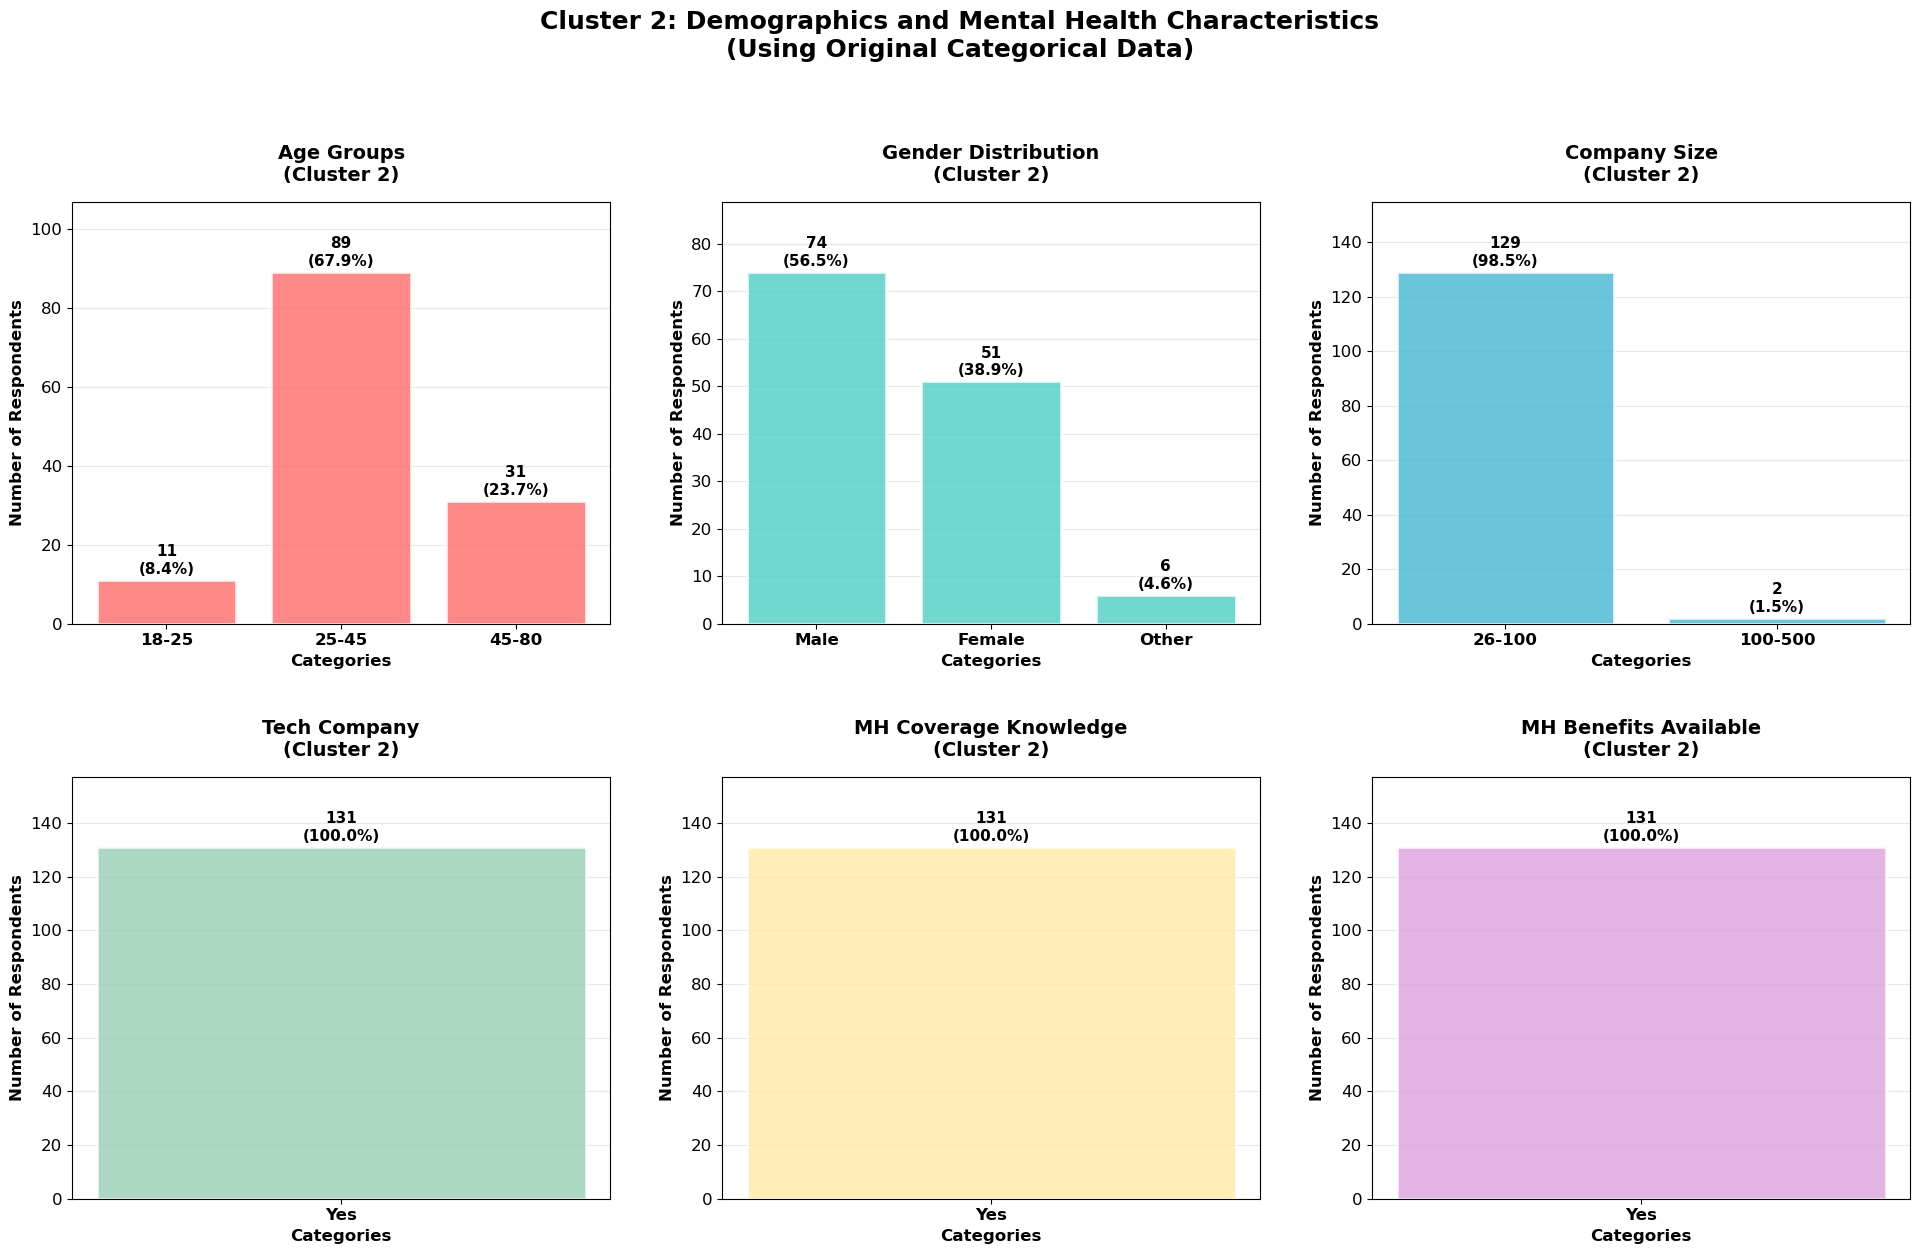

CLUSTER 2 SUMMARY
Total respondents in Cluster 2: 131
Percentage of total sample: 15.7%
Features analyzed: 6


In [30]:
# Cluster 2 Analysis 

# Load the original unscaled data from Excel file
print("LOADING ORIGINAL DATA")
print("="*35)

# Read the Excel file with original categorical data
df_original = pd.read_excel('mental_health_features_cleaned.xlsx')
print(f"✅ Loaded original data: {df_original.shape}")

# Add cluster labels from the scaled data to the original data
# Make sure the order matches
df_original['cluster'] = df_clustered['cluster'].values
print(f"✅ Added cluster labels to original data")

# Filter for Cluster 2 only
cluster_2_original = df_original[df_original['cluster'] == 2].copy()
cluster_2_size = len(cluster_2_original)

print(f"✅ Cluster 2 sample size: {cluster_2_size} respondents")
print()

# Prepare age groups from the actual age values
cluster_2_original['age_group'] = pd.cut(cluster_2_original['age_clean'], 
                                       bins=[18, 25, 45, 80], 
                                       labels=['18-25', '25-45', '45-80'], 
                                       include_lowest=True)

# Define the features to analyze
features_config = [
    {'column': 'age_group', 'title': 'Age Groups'},
    {'column': 'gender_clean', 'title': 'Gender Distribution'}, 
    {'column': 'company_size', 'title': 'Company Size'},
    {'column': 'is_tech_company', 'title': 'Tech Company'},
    {'column': 'mh_coverage_knowledge', 'title': 'MH Coverage Knowledge'},
    {'column': 'mh_benefits', 'title': 'MH Benefits Available'}
]

# Create a 2x3 subplot layout
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# Color palette
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']

print("CLUSTER 2 FEATURE ANALYSIS")
print("="*35)

# Create bar charts for each feature
for i, feature_config in enumerate(features_config):
    
    column = feature_config['column']
    title = feature_config['title']
    
    # Check if column exists
    if column in cluster_2_original.columns:
        # Get value counts
        value_counts = cluster_2_original[column].value_counts()
        
        # Remove any NaN values
        value_counts = value_counts.dropna()
        
        # Check if we have valid data
        if len(value_counts) == 0:
            axes[i].text(0.5, 0.5, f'No valid data for\n"{title}"', 
                        ha='center', va='center', transform=axes[i].transAxes,
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
            axes[i].set_title(f'{title}\n(No Data)', fontsize=14, fontweight='bold')
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            continue
        
        # Special sorting for specific features
        if column == 'company_size':
            # Sort company sizes by logical order
            size_order = ["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"]
            # Only include sizes that exist in the data
            existing_sizes = [size for size in size_order if size in value_counts.index]
            if existing_sizes:
                value_counts = value_counts.reindex(existing_sizes)
        elif column == 'age_group':
            # Sort age groups by logical order
            age_order = ["18-25", "25-45", "45-80"]
            existing_ages = [age for age in age_order if age in value_counts.index]
            if existing_ages:
                value_counts = value_counts.reindex(existing_ages)
        elif column == 'mh_coverage_knowledge':
            # Sort knowledge responses logically
            knowledge_order = ["Yes", "No", "I am not sure"]
            existing_knowledge = [resp for resp in knowledge_order if resp in value_counts.index]
            if existing_knowledge:
                value_counts = value_counts.reindex(existing_knowledge)
        elif column == 'mh_benefits':
            # Sort benefits responses logically
            benefits_order = ["Yes", "No", "I don't know", "Not eligible for coverage / N/A"]
            existing_benefits = [resp for resp in benefits_order if resp in value_counts.index]
            if existing_benefits:
                value_counts = value_counts.reindex(existing_benefits)
        elif column == 'is_tech_company':
            # Convert 0/1 to No/Yes for display
            tech_map = {0: "No", 1: "Yes"}
            value_counts.index = value_counts.index.map(lambda x: tech_map.get(x, str(x)))
        
        # Remove any NaN values after reindexing
        value_counts = value_counts.dropna()
        
        # Final check
        if len(value_counts) == 0:
            axes[i].text(0.5, 0.5, f'No valid data for\n"{title}" after processing', 
                        ha='center', va='center', transform=axes[i].transAxes,
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
            axes[i].set_title(f'{title}\n(No Data)', fontsize=14, fontweight='bold')
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            continue
        
        # Calculate percentages
        percentages = (value_counts / cluster_2_size) * 100
        
        # Create bar chart
        bars = axes[i].bar(range(len(value_counts)), value_counts.values, 
                          color=colors[i], alpha=0.8, edgecolor='white', linewidth=2)
        
        # Customize the chart
        axes[i].set_title(f'{title}\n(Cluster 2)', 
                         fontsize=14, fontweight='bold', pad=15)
        axes[i].set_xlabel('Categories', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Number of Respondents', fontsize=12, fontweight='bold')
        
        # Set x-axis labels with better formatting
        axes[i].set_xticks(range(len(value_counts)))
        
        # Determine rotation based on label length
        max_label_length = max(len(str(label)) for label in value_counts.index) if len(value_counts.index) > 0 else 0
        rotation = 0 if max_label_length < 10 else 45
        ha_alignment = 'center' if max_label_length < 10 else 'right'
        
        axes[i].set_xticklabels(value_counts.index, rotation=rotation, 
                               ha=ha_alignment, fontweight='bold')
        
        # Add value labels on top of bars
        for j, (bar, count, pct) in enumerate(zip(bars, value_counts.values, percentages.values)):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(value_counts.values) * 0.01,
                        f'{count}\n({pct:.1f}%)', 
                        ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # Add grid for better readability
        axes[i].grid(True, alpha=0.3, axis='y')
        axes[i].set_axisbelow(True)
        
        # Adjust y-axis to accommodate labels
        max_height = max(value_counts.values)
        axes[i].set_ylim(0, max_height * 1.2)
        
        # Print summary for this feature
        print(f"{title}:")
        for idx, count in value_counts.items():
            pct = (count / cluster_2_size) * 100
            print(f"  {idx}: {count} ({pct:.1f}%)")
        print()
        
    else:
        # If feature doesn't exist, show a message
        axes[i].text(0.5, 0.5, f'Column "{column}"\nnot found in dataset', 
                    ha='center', va='center', transform=axes[i].transAxes,
                    fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[i].set_title(f'{title}\n(Not Available)', 
                         fontsize=14, fontweight='bold')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# Adjust layout for better spacing
plt.tight_layout(pad=3.0)

# Add a main title for the entire figure
fig.suptitle('Cluster 2: Demographics and Mental Health Characteristics\n(Using Original Categorical Data)', 
             fontsize=18, fontweight='bold', y=1.07)
plt.savefig('cluster2_first.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics for Cluster 2
print("CLUSTER 2 SUMMARY")
print("="*25)
print(f"Total respondents in Cluster 2: {cluster_2_size}")
print(f"Percentage of total sample: {(cluster_2_size/len(df_original))*100:.1f}%")
print(f"Features analyzed: {len(features_config)}")


CLUSTER 2 MENTAL HEALTH VARIABLES ANALYSIS
Cluster 2 sample size: 131 respondents

Past Mental Health Disorder:
  Yes: 81 (61.8%)
  No: 26 (19.8%)

Current Mental Health Disorder:
  Yes: 67 (51.1%)
  No: 34 (26.0%)

Professionally Diagnosed:
  Yes: 79 (60.3%)
  No: 52 (39.7%)

Sought Treatment:
  Yes: 97 (74.0%)
  No: 34 (26.0%)

Work Interference (Treated):
  Never: 7 (5.3%)
  Rarely: 35 (26.7%)
  Sometimes: 48 (36.6%)
  Often: 4 (3.1%)
  Not applicable to me: 37 (28.2%)

Work Interference (Untreated):
  Never: 1 (0.8%)
  Rarely: 1 (0.8%)
  Sometimes: 39 (29.8%)
  Often: 62 (47.3%)
  Not applicable to me: 28 (21.4%)



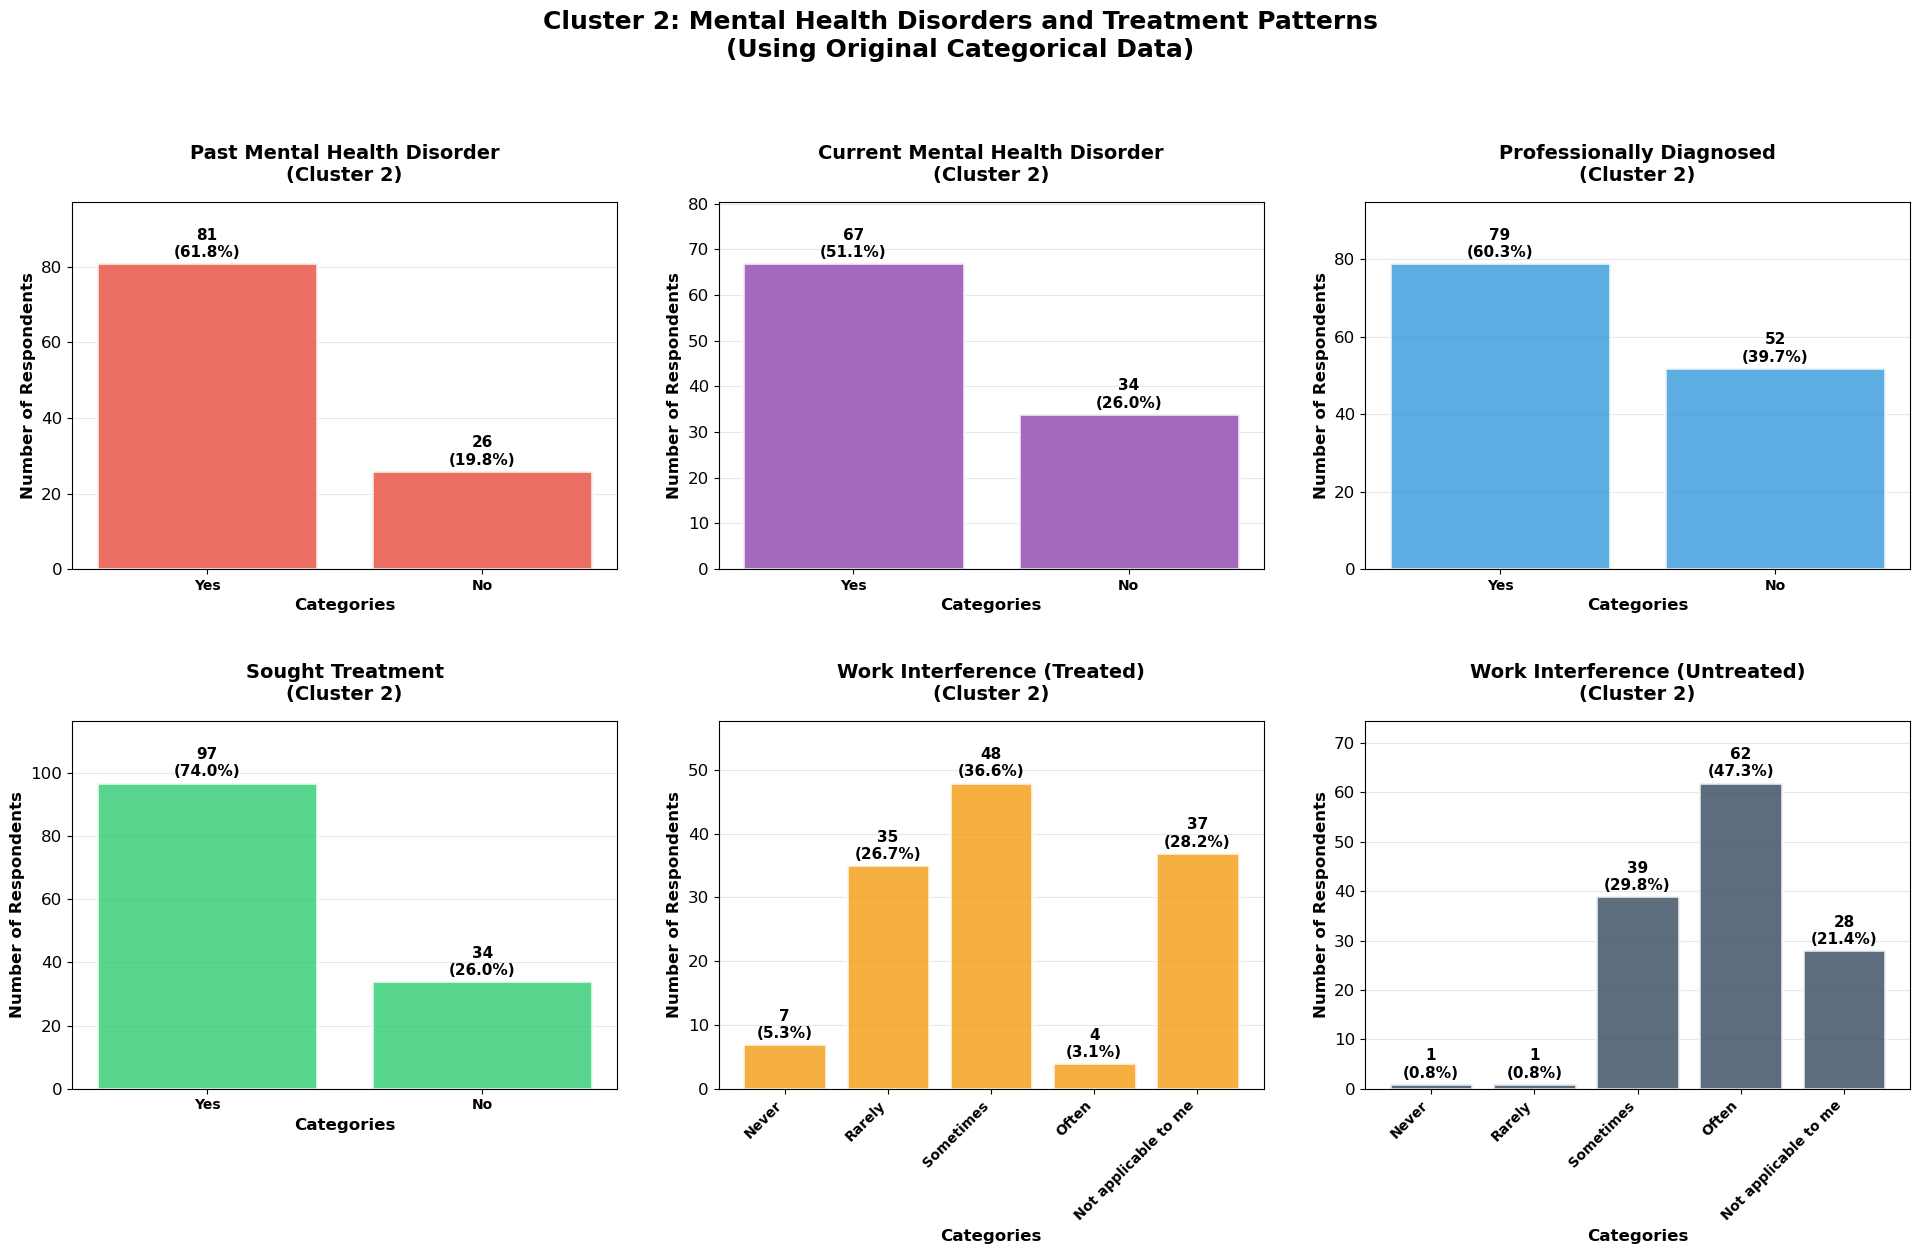

CLUSTER 2 MENTAL HEALTH SUMMARY
Past MH disorder: 81/131 (61.8%)
Current MH disorder: 67/131 (51.1%)
Sought treatment: 97/131 (74.0%)

Total respondents analyzed: 131


In [29]:
# Cluster 2 Analysis

print("\nCLUSTER 2 MENTAL HEALTH VARIABLES ANALYSIS")
print("="*45)
print(f"Cluster 2 sample size: {cluster_2_size} respondents")
print()

# Define the mental health features to analyze
mh_features_config = [
    {'column': 'past_mh_disorder', 'title': 'Past Mental Health Disorder'},
    {'column': 'current_mh_disorder', 'title': 'Current Mental Health Disorder'}, 
    {'column': 'professionally_diagnosed', 'title': 'Professionally Diagnosed'},
    {'column': 'sought_treatment', 'title': 'Sought Treatment'},
    {'column': 'work_interference_treated', 'title': 'Work Interference (Treated)'},
    {'column': 'work_interference_untreated', 'title': 'Work Interference (Untreated)'}
]

# Create a 2x3 subplot layout for mental health variables
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# Different color palette for mental health variables
mh_colors = ['#E74C3C', '#8E44AD', '#3498DB', '#2ECC71', '#F39C12', '#34495E']

# Create bar charts for each mental health feature
for i, feature_config in enumerate(mh_features_config):
    
    column = feature_config['column']
    title = feature_config['title']
    
    # Check if column exists
    if column in cluster_2_original.columns:
        # Handle the sought_treatment column which might be 0/1
        if column == 'sought_treatment':
            # Convert 0/1 to No/Yes for display
            cluster_2_display = cluster_2_original.copy()
            treatment_map = {0: "No", 1: "Yes"}
            cluster_2_display[column] = cluster_2_original[column].map(lambda x: treatment_map.get(x, str(x)))
            value_counts = cluster_2_display[column].value_counts()
        else:
            # Get value counts for other columns
            value_counts = cluster_2_original[column].value_counts()
        
        # Remove any NaN values
        value_counts = value_counts.dropna()
        
        # Check if we have valid data
        if len(value_counts) == 0:
            axes[i].text(0.5, 0.5, f'No valid data for\n"{title}"', 
                        ha='center', va='center', transform=axes[i].transAxes,
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
            axes[i].set_title(f'{title}\n(No Data)', fontsize=14, fontweight='bold')
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            continue
        
        # Special sorting for specific features
        if column in ['past_mh_disorder', 'current_mh_disorder', 'professionally_diagnosed', 'sought_treatment']:
            # Sort Yes/No responses with Yes first
            yn_order = ["Yes", "No"]
            existing_yn = [resp for resp in yn_order if resp in value_counts.index]
            if existing_yn:
                value_counts = value_counts.reindex(existing_yn)
        elif column in ['work_interference_treated', 'work_interference_untreated']:
            # Sort work interference responses logically
            interference_order = ["Never", "Rarely", "Sometimes", "Often", "Not applicable to me"]
            existing_interference = [resp for resp in interference_order if resp in value_counts.index]
            if existing_interference:
                value_counts = value_counts.reindex(existing_interference)
        
        # Remove any NaN values after reindexing
        value_counts = value_counts.dropna()
        
        # Final check
        if len(value_counts) == 0:
            axes[i].text(0.5, 0.5, f'No valid data for\n"{title}" after processing', 
                        ha='center', va='center', transform=axes[i].transAxes,
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
            axes[i].set_title(f'{title}\n(No Data)', fontsize=14, fontweight='bold')
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            continue
        
        # Calculate percentages
        percentages = (value_counts / cluster_2_size) * 100
        
        # Create bar chart
        bars = axes[i].bar(range(len(value_counts)), value_counts.values, 
                          color=mh_colors[i], alpha=0.8, edgecolor='white', linewidth=2)
        
        # Customize the chart
        axes[i].set_title(f'{title}\n(Cluster 2)', 
                         fontsize=14, fontweight='bold', pad=15)
        axes[i].set_xlabel('Categories', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Number of Respondents', fontsize=12, fontweight='bold')
        
        # Set x-axis labels with better formatting
        axes[i].set_xticks(range(len(value_counts)))
        
        # Determine rotation based on label length
        max_label_length = max(len(str(label)) for label in value_counts.index) if len(value_counts.index) > 0 else 0
        rotation = 0 if max_label_length < 12 else 45
        ha_alignment = 'center' if max_label_length < 12 else 'right'
        
        axes[i].set_xticklabels(value_counts.index, rotation=rotation, 
                               ha=ha_alignment, fontweight='bold', fontsize=10)
        
        # Add value labels on top of bars
        for j, (bar, count, pct) in enumerate(zip(bars, value_counts.values, percentages.values)):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(value_counts.values) * 0.01,
                        f'{count}\n({pct:.1f}%)', 
                        ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # Add grid for better readability
        axes[i].grid(True, alpha=0.3, axis='y')
        axes[i].set_axisbelow(True)
        
        # Adjust y-axis to accommodate labels
        max_height = max(value_counts.values)
        axes[i].set_ylim(0, max_height * 1.2)
        
        # Print summary for this feature
        print(f"{title}:")
        for idx, count in value_counts.items():
            pct = (count / cluster_2_size) * 100
            print(f"  {idx}: {count} ({pct:.1f}%)")
        print()
        
    else:
        # If feature doesn't exist, show a message
        axes[i].text(0.5, 0.5, f'Column "{column}"\nnot found in dataset', 
                    ha='center', va='center', transform=axes[i].transAxes,
                    fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[i].set_title(f'{title}\n(Not Available)', 
                         fontsize=14, fontweight='bold')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# Adjust layout for better spacing
plt.tight_layout(pad=3.0)

# Add a main title for the entire figure
fig.suptitle('Cluster 2: Mental Health Disorders and Treatment Patterns\n(Using Original Categorical Data)', 
             fontsize=18, fontweight='bold', y=1.07)

plt.savefig('cluster2_second.png', dpi=300, bbox_inches='tight')

plt.show()

# Additional summary analysis
print("CLUSTER 2 MENTAL HEALTH SUMMARY")
print("="*35)

# Calculate some key mental health statistics for Cluster 2
if 'past_mh_disorder' in cluster_2_original.columns:
    past_mh_yes = (cluster_2_original['past_mh_disorder'] == 'Yes').sum()
    print(f"Past MH disorder: {past_mh_yes}/{cluster_2_size} ({(past_mh_yes/cluster_2_size)*100:.1f}%)")

if 'current_mh_disorder' in cluster_2_original.columns:
    current_mh_yes = (cluster_2_original['current_mh_disorder'] == 'Yes').sum()
    print(f"Current MH disorder: {current_mh_yes}/{cluster_2_size} ({(current_mh_yes/cluster_2_size)*100:.1f}%)")

if 'sought_treatment' in cluster_2_original.columns:
    sought_treatment_yes = (cluster_2_original['sought_treatment'] == 1).sum()
    print(f"Sought treatment: {sought_treatment_yes}/{cluster_2_size} ({(sought_treatment_yes/cluster_2_size)*100:.1f}%)")

print(f"\nTotal respondents analyzed: {cluster_2_size}")

In [25]:
# Cluster 2 Analysis

print("\nCLUSTER 2 COMPREHENSIVE FEATURE ANALYSIS")
print("="*50)
print(f"Total respondents in Cluster 2: {cluster_2_size}")
print("="*50)
print()

# Define all features to analyze with their display names
all_features = [
    # Demographics
    ('age_group', 'Age Groups'),
    ('gender_clean', 'Gender Distribution'),
    ('self_employed', 'Self Employed'),
    
    # Company Information
    ('company_size', 'Company Size'),
    ('is_tech_company', 'Tech Company'),
    ('work_remotely', 'Work Remotely'),
    
    # Mental Health Benefits & Knowledge
    ('mh_benefits', 'MH Benefits Available'),
    ('mh_coverage_knowledge', 'MH Coverage Knowledge'),
    ('employer_mh_discussion', 'Employer MH Discussion Comfort'),
    ('employer_mh_resources', 'Employer Provides MH Resources'),
    ('anonymity_protected', 'Anonymity Protected'),
    ('leave_difficulty', 'Taking Mental Health Leave Difficulty'),
    ('employer_mh_consequences', 'Employer MH Consequences'),
    ('employer_ph_consequences', 'Employer Physical Health Consequences'),
    
    # Workplace Comfort & Attitudes
    ('coworker_mh_comfort', 'Coworker MH Discussion Comfort'),
    ('supervisor_mh_comfort', 'Supervisor MH Discussion Comfort'),
    ('mh_ph_equality', 'Mental Health = Physical Health Treatment'),
    ('observed_consequences', 'Observed Negative Consequences'),
    
    # Previous Employers (if applicable)
    ('has_prev_employers', 'Has Previous Employers'),
    ('prev_mh_benefits', 'Previous Employers: MH Benefits'),
    ('prev_mh_coverage_knowledge', 'Previous Employers: MH Coverage Knowledge'),
    ('prev_employer_mh_discussion', 'Previous Employers: MH Discussion'),
    ('prev_employer_mh_resources', 'Previous Employers: MH Resources'),
    ('prev_anonymity_protected', 'Previous Employers: Anonymity Protected'),
    ('prev_employer_mh_consequences', 'Previous Employers: MH Consequences'),
    ('prev_employer_ph_consequences', 'Previous Employers: PH Consequences'),
    ('prev_coworker_mh_willingness', 'Previous Employers: Coworker MH Willingness'),
    ('prev_supervisor_mh_willingness', 'Previous Employers: Supervisor MH Willingness'),
    ('prev_mh_ph_equality', 'Previous Employers: MH/PH Equality'),
    ('prev_observed_consequences', 'Previous Employers: Observed Consequences'),
    
    # Interview & Career Impact
    ('interview_ph_discussion', 'Interview: Physical Health Discussion'),
    ('interview_mh_discussion', 'Interview: Mental Health Discussion'),
    ('mh_hurt_career', 'Mental Health Could Hurt Career'),
    ('coworkers_negative_view', 'Coworkers Would View Negatively'),
    
    # Family & Social
    ('family_sharing_willingness', 'Family Sharing Willingness'),
    ('unsupportive_response', 'Experienced Unsupportive Response'),
    ('family_history_mh', 'Family History of Mental Health'),
    
    # Personal Mental Health
    ('past_mh_disorder', 'Past Mental Health Disorder'),
    ('current_mh_disorder', 'Current Mental Health Disorder'),
    ('professionally_diagnosed', 'Professionally Diagnosed'),
    ('sought_treatment', 'Sought Treatment'),
    ('work_interference_treated', 'Work Interference (When Treated)'),
    ('work_interference_untreated', 'Work Interference (When Untreated)')
]

# Function to convert certain binary columns to Yes/No
def convert_binary_to_yesno(series):
    """Convert 0/1 or similar binary values to Yes/No"""
    return series.map({0: "No", 1: "Yes"}).fillna(series)

# Process and display each feature
for column, display_name in all_features:
    if column in cluster_2_original.columns:
        # Special handling for certain columns
        if column in ['self_employed', 'is_tech_company', 'work_remotely', 'has_prev_employers', 
                      'sought_treatment', 'past_mh_disorder', 'current_mh_disorder', 
                      'professionally_diagnosed']:
            # Convert binary to Yes/No for better readability
            data_to_analyze = convert_binary_to_yesno(cluster_2_original[column])
        else:
            data_to_analyze = cluster_2_original[column]
        
        # Get value counts
        value_counts = data_to_analyze.value_counts().dropna()
        
        if len(value_counts) > 0:
            print(f"{display_name}:")
            
            # Sort certain categories logically (but include ALL existing values)
            if column == 'company_size':
                size_order = ["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"]
                # Include existing values in preferred order, plus any others not in the list
                ordered_values = [size for size in size_order if size in value_counts.index]
                other_values = [x for x in value_counts.index if x not in size_order]
                value_counts = value_counts.reindex(ordered_values + other_values)
            elif column == 'age_group':
                age_order = ["18-25", "25-45", "45-80"]
                ordered_values = [age for age in age_order if age in value_counts.index]
                other_values = [x for x in value_counts.index if x not in age_order]
                value_counts = value_counts.reindex(ordered_values + other_values)
            elif 'interference' in column:
                interference_order = ["Never", "Rarely", "Sometimes", "Often", "Not applicable to me"]
                ordered_values = [resp for resp in interference_order if resp in value_counts.index]
                other_values = [x for x in value_counts.index if x not in interference_order]
                value_counts = value_counts.reindex(ordered_values + other_values)
            elif column in ['mh_coverage_knowledge', 'prev_mh_coverage_knowledge']:
                knowledge_order = ["Yes", "No", "I am not sure", "N/A (not currently aware)"]
                ordered_values = [resp for resp in knowledge_order if resp in value_counts.index]
                other_values = [x for x in value_counts.index if x not in knowledge_order]
                value_counts = value_counts.reindex(ordered_values + other_values)
            elif column in ['mh_benefits', 'prev_mh_benefits']:
                benefits_order = ["Yes", "No", "I don't know", "Not eligible for coverage / N/A"]
                ordered_values = [resp for resp in benefits_order if resp in value_counts.index]
                other_values = [x for x in value_counts.index if x not in benefits_order]
                value_counts = value_counts.reindex(ordered_values + other_values)
            elif 'Yes' in value_counts.index and 'No' in value_counts.index:
                # For Yes/No questions, show Yes first
                yn_order = ["Yes", "No"]
                ordered_values = [resp for resp in yn_order if resp in value_counts.index]
                other_values = [x for x in value_counts.index if x not in yn_order]
                value_counts = value_counts.reindex(ordered_values + other_values)
            
            # Remove NaN values after reindexing
            value_counts = value_counts.dropna()
            
            # Display each value with count and percentage
            for value, count in value_counts.items():
                percentage = (count / cluster_2_size) * 100
                print(f"  {value}: {count} ({percentage:.1f}%)")
            
            print()  # Empty line for readability
        else:
            print(f"{display_name}: No valid data")
            print()
    else:
        print(f"{display_name}: Column not found in dataset")
        print()

print("="*50)
print(f"SUMMARY: {cluster_2_size} total respondents analyzed across {len(all_features)} features")
print("="*50)


CLUSTER 2 COMPREHENSIVE FEATURE ANALYSIS
Total respondents in Cluster 2: 131

Age Groups:
  18-25: 11 (8.4%)
  25-45: 89 (67.9%)
  45-80: 31 (23.7%)

Gender Distribution:
  Male: 74 (56.5%)
  Female: 51 (38.9%)
  Other: 6 (4.6%)

Self Employed:
  Yes: 129 (98.5%)
  No: 2 (1.5%)

Company Size:
  26-100: 129 (98.5%)
  100-500: 2 (1.5%)

Tech Company:
  Yes: 131 (100.0%)

Work Remotely:
  Always: 63 (48.1%)
  Sometimes: 62 (47.3%)
  Never: 6 (4.6%)

MH Benefits Available:
  Yes: 131 (100.0%)

MH Coverage Knowledge:
  Yes: 131 (100.0%)

Employer MH Discussion Comfort:
  No: 131 (100.0%)

Employer Provides MH Resources:
  Yes: 1 (0.8%)
  No: 130 (99.2%)

Anonymity Protected:
  I don't know: 130 (99.2%)
  Yes: 1 (0.8%)

Taking Mental Health Leave Difficulty:
  Somewhat easy: 131 (100.0%)

Employer MH Consequences:
  Maybe: 131 (100.0%)

Employer Physical Health Consequences:
  No: 130 (99.2%)
  Maybe: 1 (0.8%)

Coworker MH Discussion Comfort:
  Maybe: 131 (100.0%)

Supervisor MH Discussion 

## Cluster comparison

This section creates comprehensive side-by-side comparisons of all three clusters through structured tables and multi-panel visualizations. It contrasts key metrics across demographics, employment patterns, mental health status, benefits access, work interference, and stigma concerns to clearly identify what distinguishes each cluster, ultimately revealing three distinct profiles: high mental health needs employees, low mental health needs employees, and self-employed individuals with moderate needs.

In [26]:
# Create comprehensive comparison table for the three mental health clusters
print("MENTAL HEALTH CLUSTERS COMPARISON TABLE")
print("=" * 100)
print()

# Define the metrics and data for each cluster
metrics = [
    "DEMOGRAPHICS & EMPLOYMENT",
    "  Total Respondents",
    "  Percentage of Sample", 
    "  Age Group (25-45)",
    "  Gender (Male)",
    "  Self Employed (Yes)",
    "",
    "COMPANY & WORK SETUP",
    "  Tech Company (Yes)",
    "  Work Remotely (Always)",
    "  Company Size (26-100)",
    "",
    "MENTAL HEALTH BENEFITS",
    "  MH Benefits Available (Yes)",
    "  MH Coverage Knowledge (Yes)",
    "  Employer Discussion Comfort (No)",
    "",
    "MENTAL HEALTH STATUS",
    "  Past MH Disorder (Yes)",
    "  Current MH Disorder (Yes)",
    "  Professionally Diagnosed (Yes)",
    "  Sought Treatment (Yes)",
    "",
    "WORK IMPACT",
    "  Work Interf Treated (Never)",
    "  Work Interf Untreated (Often)",
    "",
    "STIGMA & CONCERNS",
    "  Could Hurt Career (Yes)",
    "  Coworkers View Negatively (Yes)",
    "  Family History MH (Yes)"
]

cluster_0_data = [
    "",
    "426", "51.0%", "78.6%", "64.1%", "0.0%",
    "",
    "", "76.3%", "20.0%", "25.8%",
    "",
    "", "68.8%", "49.1%", "72.1%",
    "",
    "", "88.3%", "72.8%", "88.5%", "95.1%",
    "",
    "", "12.4%", "61.7%",
    "",
    "", "39.4%", "29.6%", "70.4%"
]

cluster_1_data = [
    "",
    "278", "33.3%", "80.9%", "78.8%", "0.0%",
    "",
    "", "75.5%", "23.4%", "24.8%",
    "",
    "", "46.8%", "23.0%", "69.4%",
    "",
    "", "7.6%", "5.0%", "5.0%", "16.5%",
    "",
    "", "5.4%", "9.0%",
    "",
    "", "37.8%", "25.5%", "28.1%"
]

cluster_2_data = [
    "",
    "131", "15.7%", "67.9%", "56.5%", "98.5%",
    "",
    "", "100.0%", "48.1%", "98.5%",
    "",
    "", "100.0%", "100.0%", "100.0%",
    "",
    "", "61.8%", "51.1%", "60.3%", "74.0%",
    "",
    "", "5.3%", "47.3%",
    "",
    "", "43.5%", "40.5%", "55.0%"
]

# Create DataFrame
comparison_data = {
    'Metric': metrics,
    'Cluster 0 (High MH)': cluster_0_data,
    'Cluster 1 (Low MH)': cluster_1_data,
    'Cluster 2 (Self-Emp)': cluster_2_data
}

df_comparison = pd.DataFrame(comparison_data)

# Display the table with proper formatting
print(f"{'Metric':<35} {'Cluster 0':<12} {'Cluster 1':<12} {'Cluster 2':<12}")
print(f"{'':35} {'(High MH)':<12} {'(Low MH)':<12} {'(Self-Emp)':<12}")
print("-" * 75)

for i, row in df_comparison.iterrows():
    if row['Metric'] == "":
        print()
        continue
    print(f"{row['Metric']:<35} {row['Cluster 0 (High MH)']:<12} {row['Cluster 1 (Low MH)']:<12} {row['Cluster 2 (Self-Emp)']:<12}")

print()
print("=" * 100)
print("CLUSTER PROFILES:")
print()
print("🔴 CLUSTER 0 (High Mental Health Needs - 51% of sample):")
print("   • Traditional employees with severe mental health burden")
print("   • 95% sought treatment, 73% currently have disorders")
print("   • High work interference when untreated (62%)")
print()
print("🟢 CLUSTER 1 (Low Mental Health Needs - 33% of sample):")
print("   • Traditional employees with minimal mental health issues")
print("   • Only 5% currently have disorders, 17% sought treatment")
print("   • Represents the 'mentally healthy' workforce")
print()
print("🟡 CLUSTER 2 (Self-Employed Moderate Needs - 16% of sample):")
print("   • Self-employed with moderate mental health burden")
print("   • 100% have benefits access (self-managed)")
print("   • 74% sought treatment, moderate work interference")
print("=" * 100)

# Also create a clean pandas DataFrame for further analysis if needed
df_clean = pd.DataFrame({
    'Metric': [
        'Total Respondents', 'Percentage of Sample', 'Age Group (25-45)', 
        'Gender (Male)', 'Self Employed (Yes)', 'Tech Company (Yes)',
        'Work Remotely (Always)', 'MH Benefits Available (Yes)',
        'MH Coverage Knowledge (Yes)', 'Past MH Disorder (Yes)',
        'Current MH Disorder (Yes)', 'Professionally Diagnosed (Yes)',
        'Sought Treatment (Yes)', 'Work Interference Untreated (Often)',
        'Could Hurt Career (Yes)', 'Family History MH (Yes)'
    ],
    'Cluster 0 (High MH)': [
        '426', '51.0%', '78.6%', '64.1%', '0.0%', '76.3%',
        '20.0%', '68.8%', '49.1%', '88.3%', '72.8%', '88.5%',
        '95.1%', '61.7%', '39.4%', '70.4%'
    ],
    'Cluster 1 (Low MH)': [
        '278', '33.3%', '80.9%', '78.8%', '0.0%', '75.5%',
        '23.4%', '46.8%', '23.0%', '7.6%', '5.0%', '5.0%',
        '16.5%', '9.0%', '37.8%', '28.1%'
    ],
    'Cluster 2 (Self-Emp)': [
        '131', '15.7%', '67.9%', '56.5%', '98.5%', '100.0%',
        '48.1%', '100.0%', '100.0%', '61.8%', '51.1%', '60.3%',
        '74.0%', '47.3%', '43.5%', '55.0%'
    ]
})

MENTAL HEALTH CLUSTERS COMPARISON TABLE

Metric                              Cluster 0    Cluster 1    Cluster 2   
                                    (High MH)    (Low MH)     (Self-Emp)  
---------------------------------------------------------------------------
DEMOGRAPHICS & EMPLOYMENT                                                 
  Total Respondents                 426          278          131         
  Percentage of Sample              51.0%        33.3%        15.7%       
  Age Group (25-45)                 78.6%        80.9%        67.9%       
  Gender (Male)                     64.1%        78.8%        56.5%       
  Self Employed (Yes)               0.0%         0.0%         98.5%       

COMPANY & WORK SETUP                                                      
  Tech Company (Yes)                76.3%        75.5%        100.0%      
  Work Remotely (Always)            20.0%        23.4%        48.1%       
  Company Size (26-100)             25.8%        24.8%   

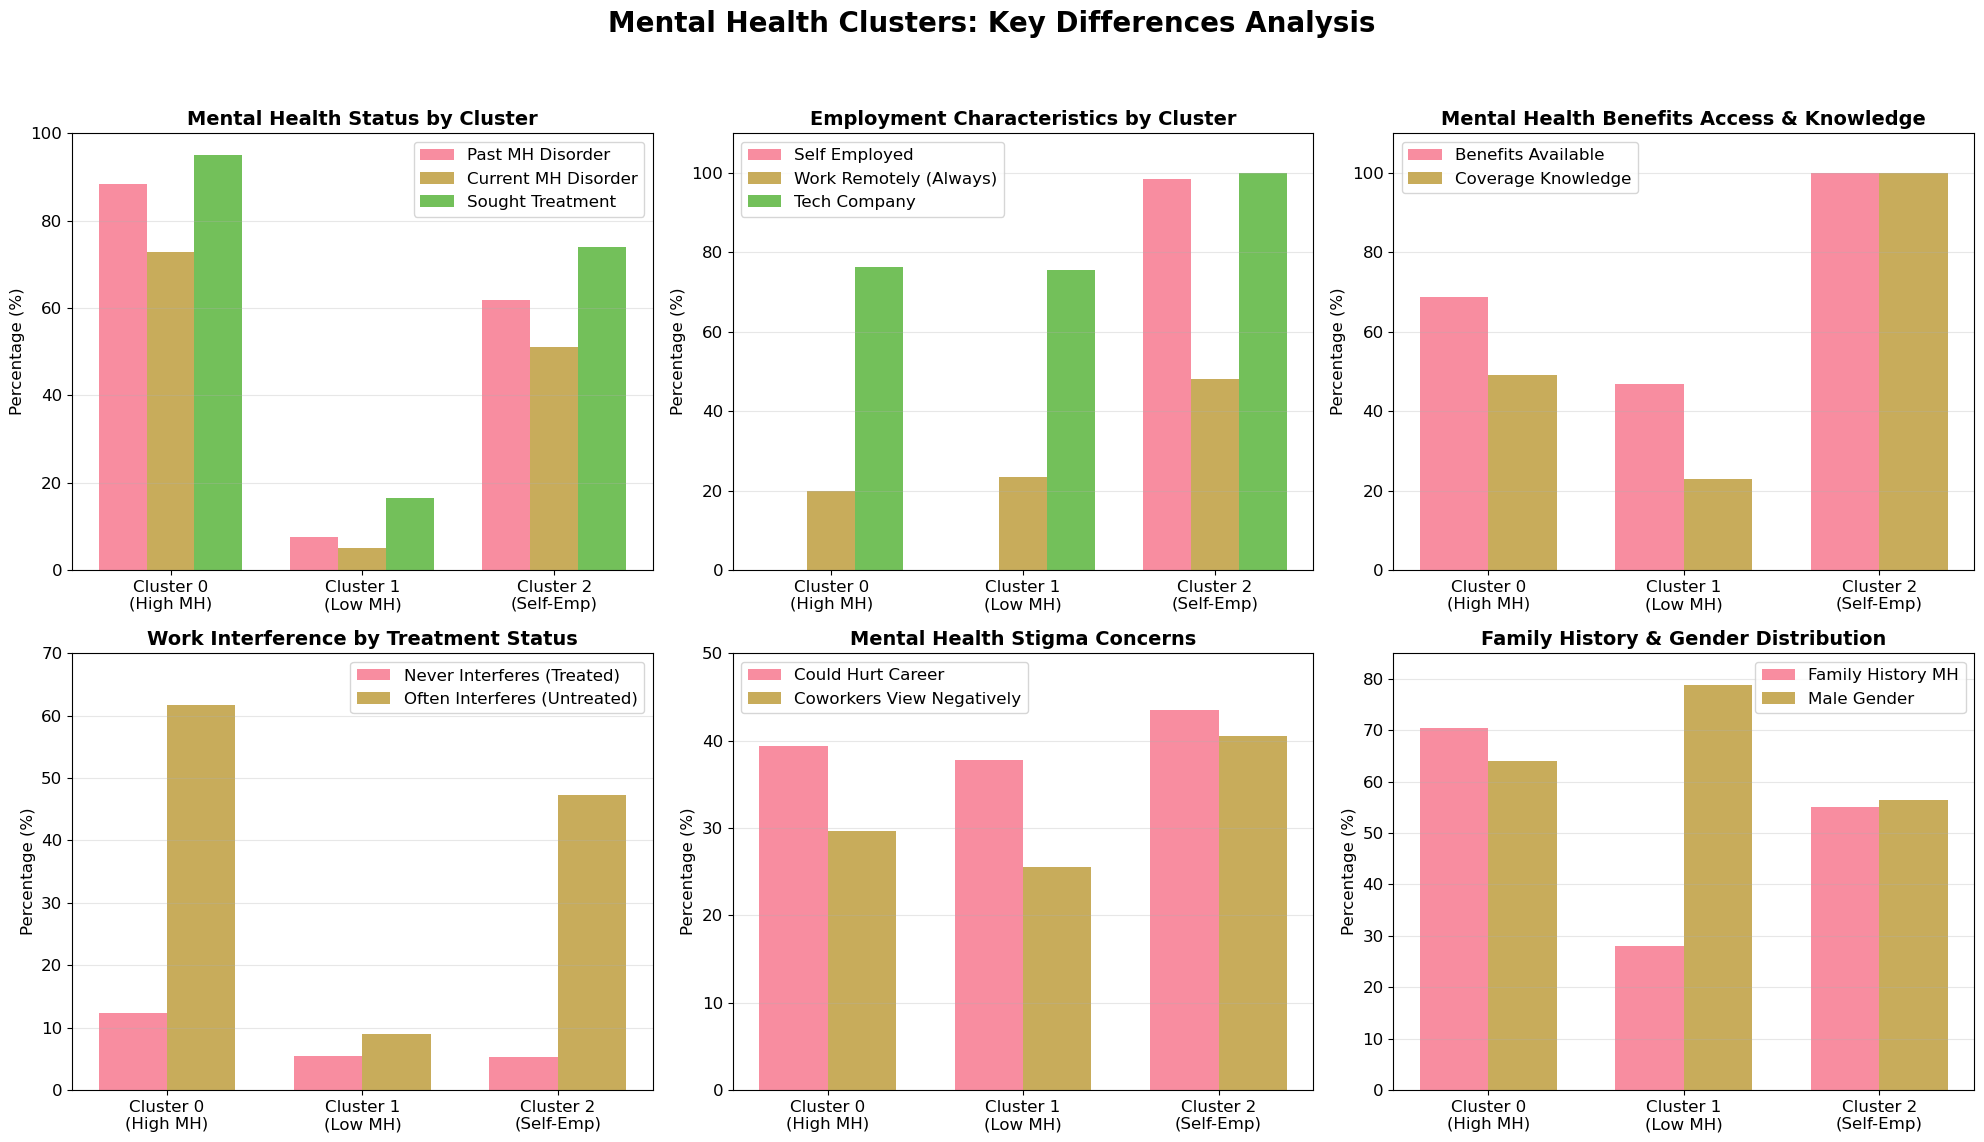


KEY INSIGHTS FROM VISUALIZATIONS:

📊 MENTAL HEALTH STATUS:
   • Cluster 0 shows extreme mental health burden (88% past, 73% current disorders)
   • Cluster 1 represents the 'healthy' workforce (only 5% current disorders)
   • Cluster 2 has moderate burden (62% past, 51% current disorders)

🏢 EMPLOYMENT PATTERNS:
   • Clusters 0 & 1: Traditional employees (0% self-employed)
   • Cluster 2: Almost entirely self-employed (98.5%)
   • Self-employed group works remotely much more (48% vs ~20%)

💼 BENEFITS & KNOWLEDGE:
   • Self-employed (Cluster 2) have universal benefits access (100%)
   • Traditional employees show gaps in benefits and knowledge
   • Cluster 1 (low MH needs) least informed about benefits (23%)

⚠️ WORK INTERFERENCE:
   • Untreated mental health severely impacts work in Clusters 0 & 2
   • Cluster 0: 62% report 'often' interference when untreated
   • Cluster 1: Minimal work interference (9% untreated often)

🤫 STIGMA CONCERNS:
   • Consistent career concerns across all c

In [27]:
# Set style for clean, professional charts
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

# Create figure with 6 subplots (2x3 layout)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Mental Health Clusters: Key Differences Analysis', fontsize=20, fontweight='bold', y=0.98)

# Define colors for each cluster
colors = ['#E74C3C', '#2ECC71', '#F39C12']  # Red, Green, Orange
cluster_names = ['Cluster 0\n(High MH)', 'Cluster 1\n(Low MH)', 'Cluster 2\n(Self-Emp)']

# ========================================
# CHART 1: Mental Health Status Overview
# ========================================
ax1 = axes[0, 0]

mh_status_data = {
    'Past MH Disorder': [88.3, 7.6, 61.8],
    'Current MH Disorder': [72.8, 5.0, 51.1],
    'Sought Treatment': [95.1, 16.5, 74.0]
}

x = np.arange(len(cluster_names))
width = 0.25

for i, (label, values) in enumerate(mh_status_data.items()):
    ax1.bar(x + i*width, values, width, label=label, alpha=0.8)

ax1.set_title('Mental Health Status by Cluster', fontweight='bold', fontsize=14)
ax1.set_ylabel('Percentage (%)')
ax1.set_xticks(x + width)
ax1.set_xticklabels(cluster_names)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, 100)

# ========================================
# CHART 2: Employment & Work Setup
# ========================================
ax2 = axes[0, 1]

employment_data = {
    'Self Employed': [0.0, 0.0, 98.5],
    'Work Remotely (Always)': [20.0, 23.4, 48.1],
    'Tech Company': [76.3, 75.5, 100.0]
}

x = np.arange(len(cluster_names))
width = 0.25

for i, (label, values) in enumerate(employment_data.items()):
    ax2.bar(x + i*width, values, width, label=label, alpha=0.8)

ax2.set_title('Employment Characteristics by Cluster', fontweight='bold', fontsize=14)
ax2.set_ylabel('Percentage (%)')
ax2.set_xticks(x + width)
ax2.set_xticklabels(cluster_names)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 110)

# ========================================
# CHART 3: Benefits Access & Knowledge
# ========================================
ax3 = axes[0, 2]

benefits_data = {
    'Benefits Available': [68.8, 46.8, 100.0],
    'Coverage Knowledge': [49.1, 23.0, 100.0]
}

x = np.arange(len(cluster_names))
width = 0.35

for i, (label, values) in enumerate(benefits_data.items()):
    ax3.bar(x + i*width, values, width, label=label, alpha=0.8)

ax3.set_title('Mental Health Benefits Access & Knowledge', fontweight='bold', fontsize=14)
ax3.set_ylabel('Percentage (%)')
ax3.set_xticks(x + width/2)
ax3.set_xticklabels(cluster_names)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim(0, 110)

# ========================================
# CHART 4: Work Interference Patterns
# ========================================
ax4 = axes[1, 0]

interference_data = {
    'Never Interferes (Treated)': [12.4, 5.4, 5.3],
    'Often Interferes (Untreated)': [61.7, 9.0, 47.3]
}

x = np.arange(len(cluster_names))
width = 0.35

for i, (label, values) in enumerate(interference_data.items()):
    ax4.bar(x + i*width, values, width, label=label, alpha=0.8)

ax4.set_title('Work Interference by Treatment Status', fontweight='bold', fontsize=14)
ax4.set_ylabel('Percentage (%)')
ax4.set_xticks(x + width/2)
ax4.set_xticklabels(cluster_names)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_ylim(0, 70)

# ========================================
# CHART 5: Workplace Stigma & Concerns
# ========================================
ax5 = axes[1, 1]

stigma_data = {
    'Could Hurt Career': [39.4, 37.8, 43.5],
    'Coworkers View Negatively': [29.6, 25.5, 40.5]
}

x = np.arange(len(cluster_names))
width = 0.35

for i, (label, values) in enumerate(stigma_data.items()):
    ax5.bar(x + i*width, values, width, label=label, alpha=0.8)

ax5.set_title('Mental Health Stigma Concerns', fontweight='bold', fontsize=14)
ax5.set_ylabel('Percentage (%)')
ax5.set_xticks(x + width/2)
ax5.set_xticklabels(cluster_names)
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')
ax5.set_ylim(0, 50)

# ========================================
# CHART 6: Family History & Gender Patterns
# ========================================
ax6 = axes[1, 2]

family_gender_data = {
    'Family History MH': [70.4, 28.1, 55.0],
    'Male Gender': [64.1, 78.8, 56.5]
}

x = np.arange(len(cluster_names))
width = 0.35

for i, (label, values) in enumerate(family_gender_data.items()):
    ax6.bar(x + i*width, values, width, label=label, alpha=0.8)

ax6.set_title('Family History & Gender Distribution', fontweight='bold', fontsize=14)
ax6.set_ylabel('Percentage (%)')
ax6.set_xticks(x + width/2)
ax6.set_xticklabels(cluster_names)
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')
ax6.set_ylim(0, 85)

# Adjust layout and display
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('mental_health_clusters_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ========================================
# SUMMARY INSIGHTS
# ========================================
print("\n" + "="*80)
print("KEY INSIGHTS FROM VISUALIZATIONS:")
print("="*80)
print()
print("📊 MENTAL HEALTH STATUS:")
print("   • Cluster 0 shows extreme mental health burden (88% past, 73% current disorders)")
print("   • Cluster 1 represents the 'healthy' workforce (only 5% current disorders)")
print("   • Cluster 2 has moderate burden (62% past, 51% current disorders)")
print()
print("🏢 EMPLOYMENT PATTERNS:")
print("   • Clusters 0 & 1: Traditional employees (0% self-employed)")
print("   • Cluster 2: Almost entirely self-employed (98.5%)")
print("   • Self-employed group works remotely much more (48% vs ~20%)")
print()
print("💼 BENEFITS & KNOWLEDGE:")
print("   • Self-employed (Cluster 2) have universal benefits access (100%)")
print("   • Traditional employees show gaps in benefits and knowledge")
print("   • Cluster 1 (low MH needs) least informed about benefits (23%)")
print()
print("⚠️ WORK INTERFERENCE:")
print("   • Untreated mental health severely impacts work in Clusters 0 & 2")
print("   • Cluster 0: 62% report 'often' interference when untreated")
print("   • Cluster 1: Minimal work interference (9% untreated often)")
print()
print("🤫 STIGMA CONCERNS:")
print("   • Consistent career concerns across all clusters (~38-44%)")
print("   • Self-employed (Cluster 2) most worried about coworker perceptions (41%)")
print()
print("👨‍👩‍👧‍👦 FAMILY HISTORY & GENDER:")
print("   • Strong family MH history in Cluster 0 (70%) suggests genetic/environmental factors")
print("   • Cluster 1 (low MH needs) has lowest family history (28%)")
print("   • Gender distribution varies: Cluster 1 most male-dominated (79%)")
print("   • Self-employed group (Cluster 2) most gender-balanced (57% male)")
print("="*80)

## Summary and Conclusions

This analysis successfully addressed the HR department's request to categorize technology employees based on mental health survey responses and provide actionable insights for targeted intervention programs.

### Data Processing Pipeline
- Started with 1,433 survey responses from the Mental Health in Tech Survey 2016
- Applied systematic preprocessing: geographic filtering (US-only), age validation (18-80), and gender standardization
- Reduced features from 63 to 43 through careful selection, removing free-text and high-missing columns
- Handled missing values using appropriate imputation strategies (mode for categorical, median for numeric)
- Encoded categorical variables preserving ordinal relationships where meaningful
- Standardized all features for clustering algorithms

### Clustering Analysis Results
After testing multiple algorithms (K-Means, Agglomerative Clustering, and Gaussian Mixture Models) with varying cluster counts (2-7), **Agglomerative Clustering with 3 clusters** emerged as the optimal solution with a silhouette score of 0.484.

### Key Employee Segments Identified

**Cluster 0 - High Mental Health Needs (51% of employees)**
- Traditional employees with severe mental health burden
- 95% have sought treatment, 73% currently have disorders
- 62% report frequent work interference when untreated
- Strong family history of mental health issues (70%)
- Clear target for comprehensive mental health support programs

**Cluster 1 - Low Mental Health Needs (33% of employees)**
- Traditional employees with minimal mental health issues
- Only 5% currently have disorders, 17% have sought treatment
- Represents the mentally healthy workforce
- Target for preventive wellness programs

**Cluster 2 - Self-Employed Moderate Needs (16% of employees)**
- 98.5% self-employed individuals
- Moderate mental health burden (51% current disorders)
- 100% have benefits access (self-managed)
- Different support needs due to employment structure

### Recommendations for HR Interventions
1. **Immediate Priority**: Develop comprehensive support for Cluster 0 employees including enhanced treatment access, workplace accommodations, and stigma reduction initiatives
2. **Preventive Programs**: Maintain wellness programs for Cluster 1 to prevent mental health issues
3. **Flexible Solutions**: Create adaptable resources for self-employed workers (Cluster 2) who manage their own benefits
4. **Universal Initiatives**: Address workplace stigma concerns present across all clusters (~40% fear career impact)

This clustering analysis provides HR with clear, data-driven employee segments for targeted mental health interventions, fulfilling the project objectives of reducing complexity while preserving key insights for organizational improvement.